# Street flooding problem

In Houston, TX, we are facing a challenge with flooding in an urban area. To tackle this issue, we are looking to develop a machine learning model capable of predicting the outcome of flood events based on their initial conditions. 

We have a collection of 3,000 simulated flood incidents (training set), each serving as a historical datapoint to train our model.
 
The assignment's goal is to build a data-driven model to capture the simulator's logic that generated these incidents and to replicate its predictions. Each simulated incident is unique, starting with different initial conditions, leading to varied outcomes. However, the geographical layout, including the street network and the location coordinates of each street segment, remains unchanged throughout all simulations. This consistent geographic data is available in the ‘edge_info.csv’ file.

Additionally, specific parameters that influence how the flood unfolds in each simulation are set at the beginning and differ from one incident to another. These parameters are detailed in the ‘training_parameters.csv’ and ‘test_parameters.csv’ files for the training and testing datasets, respectively.

## Important reminders
- To run this notebook and "save time" for some cells, some csvs are nedeed. Download the path with them,pickle best_model and pickle scaler from [here](https://drive.google.com/drive/folders/17Py-PnGtOgniQfk2KsqFyafWeeUkZ_vO?usp=sharing).
- In order to properly run the code, change file paths based on yours.
- In the prediction files, roads are ordered from the lowest value to the highest for both head_id and tail_id (in the original test files were ordered only based on head_id)!!!
- I wrote this notebook using Visual Studio Code. If you want to run it on colab you need mount you Google Drive.
- Most operations (NOT ALL) are made in the same cell for both training and test set. Few operations for test set are made at the end.

## Import and read file

In [176]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


#PATHS
edge_path = '/Users/francesco/Desktop/MLAssignment202324/edge_info.csv'
training_params_path = '/Users/francesco/Desktop/MLAssignment202324/training_parameters.csv'
test_params_path = '/Users/francesco/Desktop/MLAssignment202324/test_parameters.csv'
training_path = '/Users/francesco/Desktop/MLAssignment202324/training'
test_path = '/Users/francesco/Desktop/MLAssignment202324/test'
#READ FILES
edge_info = pd.read_csv(edge_path)
training_params = pd.read_csv(training_params_path)
test_params = pd.read_csv(test_params_path)

# Add to every trainig path file the ObservationIndex column and concatenate all the files in one dataframe
df_training = pd.DataFrame()
for file in os.listdir(training_path):
    if file.endswith(".csv"):
        df_file = pd.read_csv(training_path + "/" +file) #read the file
        file_name = os.path.splitext(os.path.basename(file))[0] #os.path.basename(full_path) returns the filename, and os.path.splitext(...) separates the filename from the extension. The [0] part at the end extracts only the filename without the extension.
        df_file["ObservationIndex"] = int(file_name) #add the ObservationIndex column based on the filename
        df_training = pd.concat([df_training, df_file], ignore_index=True) #concatenate all the files in one dataframe
        
        
# Add to every test path file the ObservationIndex column and concatenate all the files in one dataframe
df_test = pd.DataFrame()
for file in os.listdir(test_path):
    if file.endswith(".csv"):
        df_file = pd.read_csv(test_path + "/" +file)
        file_name = os.path.splitext(os.path.basename(file))[0]
        df_file["ObservationIndex"] = int(file_name)
        df_test = pd.concat([df_test, df_file], ignore_index=True)


In [177]:
df_training #191 rows x 3000 simulations = 573000 rows

,head_id,tail_id,flooded_init,flooded_final,ObservationIndex
0,151779659,153066427,False,False,545
1,151779659,152426116,False,False,545
2,151779659,152136099,False,False,545
3,151779763,152437059,False,True,545
4,151779763,152541741,True,True,545
...,...,...,...,...,...
572995,153295319,153341528,False,False,1976
572996,153444946,153444951,False,False,1976
572997,153456725,153456737,False,False,1976
572998,1191806314,1191806355,False,False,1976


In [178]:
df_test #191 rows x 200 simulations = 38200 rows

,head_id,tail_id,flooded_init,ObservationIndex
0,151779659,153066427,False,155
1,151779659,152426116,False,155
2,151779659,152136099,False,155
3,151779763,152437059,False,155
4,151779763,152541741,False,155
...,...,...,...,...
38195,153295319,153341528,False,158
38196,153444946,153444951,False,158
38197,153456725,153456737,False,158
38198,1191806314,1191806355,False,158


## Connectivity 
Connectivity information is really important to catch the target. Connected roads, may exhibit mutual influences.

Streets are connected if have equal tail_id or head_id.



### NEW COLUMNS: connected_altitude_score and manhattan_score 
Case where the considered road has closer center to connected roads (based on latitude and longitude coordinates) is more likely to flood, if one of the connected road is flooded_final =True. 
For each road compute the reciprocal of the average of Manhattan distance from its connected streets (higher values mean closer centers -->more likely to be influenced by connected roads)

Furthermore, there is the possibility to explore the interaction of roads at varying altitudes. Understanding the implications of elevation differences and considering factors such as slope and water flow from higher to lower roads, appears to be a critical aspect of analysis.
For each road compute the sum of absolute differences of altitude from connected streets and the street considered:
- Values near 0 means the street and its connected have similar altitudes-->so less like to influence each others.
- higher abs values mean more influencable between them (more slope)

In [179]:
# Function to calculate the Manhattan distance
def manhattan(lat1, lon1, lat2, lon2):
    # Calculate differences between coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate distance
    distance = np.abs(dlat) + np.abs(dlon)

    return distance

def connectivity(row, df):
    # Create a dataframe with all the connected streets to the current street
    connected_streets = df[
    (
     ((df['head_id'].isin([row['head_id'], row['tail_id']])) | (df['tail_id'].isin([row['head_id'], row['tail_id']]))) #connected streets including the street itself
     & ~((df['head_id'] == row['head_id']) & (df['tail_id'] == row['tail_id'])) #excluding the street itself
    )]


    # Sum of the abs differences in altitude between the connected streets and the current street 
    connected_altitude_score = np.sum(np.abs(connected_streets['altitude'] - row['altitude']))

    # Manhattan score
    distances = manhattan(row['latitude'], row['longitude'], connected_streets['latitude'], connected_streets['longitude']) #distances from connected streets
    avg_distance = np.mean(distances) #average distance from connected streets
    reciprocal_avg_distance = 1 / avg_distance #to have higher score if the street are closer (more connected and more influencable)
    

    return connected_altitude_score, reciprocal_avg_distance

# Apply the function to edge_info and create new columns
edge_info[['connected_altitude_score', 'manhattan_score']] = edge_info.apply(
    lambda row: pd.Series(connectivity(row, edge_info)),
    axis=1
)

edge_info

,head_id,tail_id,longitude,latitude,altitude,connected_altitude_score,manhattan_score
0,151779659,153066427,-95.382821,29.798740,957.0,143.3,931.387768
1,151779659,152426116,-95.383237,29.798445,921.2,334.0,839.207788
2,151779659,152136099,-95.382354,29.797764,876.0,226.3,897.021887
3,151779763,152437059,-95.380082,29.795224,897.0,124.5,823.892894
4,151779763,152541741,-95.380394,29.796295,877.6,106.4,880.669309
...,...,...,...,...,...,...,...
186,153295319,153341528,-95.386112,29.795351,828.0,358.8,1044.386423
187,153444946,153444951,-95.381934,29.790545,939.5,142.0,1182.965300
188,153456725,153456737,-95.382500,29.795060,955.8,241.0,1406.469761
189,1191806314,1191806355,-95.385248,29.790811,1011.0,282.1,1896.333755


### First merge
Having different dataframes it will be created a single dataframe with edge_info and training file of each simulation

In [180]:
#Merge the training dataframe with the edge_info dataframe based on the head_id and tail_id columns       
merged_training = pd.merge(df_training, edge_info, left_on=["head_id","tail_id"], right_on=["head_id","tail_id"]).sort_values(by=["ObservationIndex","head_id","tail_id"]) 
df_training = merged_training.reset_index(drop=True)


#Merge the test dataframe with the edge_info dataframe based on the head_id and tail_id columns 
merged_test = pd.merge(df_test, edge_info, left_on=["head_id","tail_id"], right_on=["head_id","tail_id"]).sort_values(by=["ObservationIndex","head_id","tail_id"]) 
df_test = merged_test.reset_index(drop=True)
      

df_training

,head_id,tail_id,flooded_init,flooded_final,ObservationIndex,longitude,latitude,altitude,connected_altitude_score,manhattan_score
0,151779659,152136099,False,False,0,-95.382354,29.797764,876.0,226.3,897.021887
1,151779659,152426116,False,False,0,-95.383237,29.798445,921.2,334.0,839.207788
2,151779659,153066427,False,False,0,-95.382821,29.798740,957.0,143.3,931.387768
3,151779763,152437059,False,False,0,-95.380082,29.795224,897.0,124.5,823.892894
4,151779763,152541738,False,False,0,-95.379437,29.795578,945.1,197.6,742.528309
...,...,...,...,...,...,...,...,...,...,...
572995,153295319,153341528,False,True,2999,-95.386112,29.795351,828.0,358.8,1044.386423
572996,153444946,153444951,False,False,2999,-95.381934,29.790545,939.5,142.0,1182.965300
572997,153456725,153456737,False,True,2999,-95.382500,29.795060,955.8,241.0,1406.469761
572998,1191806314,1191806355,False,False,2999,-95.385248,29.790811,1011.0,282.1,1896.333755


In [181]:
df_test

,head_id,tail_id,flooded_init,ObservationIndex,longitude,latitude,altitude,connected_altitude_score,manhattan_score
0,151779659,152136099,False,0,-95.382354,29.797764,876.0,226.3,897.021887
1,151779659,152426116,False,0,-95.383237,29.798445,921.2,334.0,839.207788
2,151779659,153066427,True,0,-95.382821,29.798740,957.0,143.3,931.387768
3,151779763,152437059,False,0,-95.380082,29.795224,897.0,124.5,823.892894
4,151779763,152541738,False,0,-95.379437,29.795578,945.1,197.6,742.528309
...,...,...,...,...,...,...,...,...,...
38195,153295319,153341528,False,199,-95.386112,29.795351,828.0,358.8,1044.386423
38196,153444946,153444951,False,199,-95.381934,29.790545,939.5,142.0,1182.965300
38197,153456725,153456737,False,199,-95.382500,29.795060,955.8,241.0,1406.469761
38198,1191806314,1191806355,False,199,-95.385248,29.790811,1011.0,282.1,1896.333755


### NEW COLUMNS: connected_altitude_score_init and manhattan_score_init 
Similar to the prevoius case but considering the connection to INITIALLY FLOODED roads (and not connection in general).

Case where the considered road has closer center to INITIALLY FLOODED connected roads (based on latitude and longitude coordinates) is more likely to flood. 
For each road compute the reciprocal of the average of Manhattan distance from its connected INITIALLY FLOODED streets (higher values mean closer centers -->more likely to flood)
(0 value means no INITIALLY FLOODED connected roads)

Furthermore, there is the possibility to explore the interaction of roads at varying altitudes. Understanding the implications of elevation differences and considering factors such as slope and water flow from higher to lower roads, appears to be a critical aspect of analysis.
For each road compute the sum of abs differences of altitude from connected INITIALLY FLOODED streets and the street considered:
- Values near 0 means the street and its connected INITIALLY FLOODED have similar altitudes-->so less like to influence each others.
- higher abs values mean more influencable between them (more slope)
- 0 value means no INITIALLY FLOODED connected roads

As to run this function takes long time ,due to dataframe dimensionality, i upload the resulting dataframe in .csv format.

In [182]:
def connectivity_init(row, df):
    # Create a dataframe with all the connected initially flooded streets to the current street in the current simulation
    connected_streets = df.loc[
    ((df['ObservationIndex'] == row['ObservationIndex']) & #same simulation
     (df['flooded_init'] == True) & #initially flooded
     ((df['head_id'].isin([row['head_id'], row['tail_id']])) | (df['tail_id'].isin([row['head_id'], row['tail_id']]))) #connected streets including the street itself
     & ~((df['head_id'] == row['head_id']) & (df['tail_id'] == row['tail_id'])) #excluding the street itself
    )]


    # Sum of the differences in altitude between the initially flooded connected streets and the current street 
    connected_altitude_score_init = np.sum(np.abs(connected_streets['altitude'] - row['altitude']))

    # Manhattan score
    distances = manhattan(row['latitude'], row['longitude'], connected_streets['latitude'], connected_streets['longitude']) #distances from initially flooded connected streets
    avg_distance = np.mean(distances) if len(distances) > 0 else 0  # if there are no connected flooded streets initially, the average distance will be 0
    reciprocal_avg_distance_init = 1/avg_distance if avg_distance != 0 else 0  # if the reciprocal is 0, it means that there are no connected flooded streets initially

    return connected_altitude_score_init, reciprocal_avg_distance_init

In [183]:
'''# Apply the function to the dataframe training and create new columns
df_training[['connected_altitude_score_init','manhattan_score_init']] = df_training.apply(
    lambda row: pd.Series(connectivity_init(row, df_training)),
    axis=1
)

# Save the dataframe training in a csv file
df_training.to_csv('/Users/francesco/Desktop/new_csv_normale+init/df_train(head+tail+flooded_init+flooded_final+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score).csv', index = False)
'''


"# Apply the function to the dataframe training and create new columns\ndf_training[['connected_altitude_score_init','manhattan_score_init']] = df_training.apply(\n    lambda row: pd.Series(connectivity_init(row, df_training)),\n    axis=1\n)\n\n# Save the dataframe training in a csv file\ndf_training.to_csv('/Users/francesco/Desktop/new_csv_normale+init/df_train(head+tail+flooded_init+flooded_final+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score).csv', index = False)\n"

In [184]:
'''# Apply the function to the dataframe test and create new columns
df_test[['connected_altitude_score_init','manhattan_score_init']] = df_test.apply(
    lambda row: pd.Series(connectivity_init(row, df_test)),
    axis=1
)

# Save the dataframe training in a csv file
df_test.to_csv('/Users/francesco/Desktop/new_csv_normale+init/df_test(head+tail+flooded_init+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score).csv', index = False)
'''


"# Apply the function to the dataframe test and create new columns\ndf_test[['connected_altitude_score_init','manhattan_score_init']] = df_test.apply(\n    lambda row: pd.Series(connectivity_init(row, df_test)),\n    axis=1\n)\n\n# Save the dataframe training in a csv file\ndf_test.to_csv('/Users/francesco/Desktop/new_csv_normale+init/df_test(head+tail+flooded_init+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score).csv', index = False)\n"

In [185]:
#Read the dataframes
df_training = pd.read_csv('/Users/francesco/Desktop/new_csv_normale+init/df_train(head+tail+flooded_init+flooded_final+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score).csv')
df_test = pd.read_csv('/Users/francesco/Desktop/new_csv_normale+init/df_test(head+tail+flooded_init+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score).csv')

df_training

,head_id,tail_id,flooded_init,flooded_final,ObservationIndex,longitude,latitude,altitude,connected_altitude_score,manhattan_score,connected_altitude_score_init,manhattan_score_init
0,151779659,152136099,False,False,0,-95.382354,29.797764,876.0,226.3,897.021887,0.0,0.000000
1,151779659,152426116,False,False,0,-95.383237,29.798445,921.2,334.0,839.207788,0.0,0.000000
2,151779659,153066427,False,False,0,-95.382821,29.798740,957.0,143.3,931.387768,0.0,0.000000
3,151779763,152437059,False,False,0,-95.380082,29.795224,897.0,124.5,823.892894,0.0,0.000000
4,151779763,152541738,False,False,0,-95.379437,29.795578,945.1,197.6,742.528309,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
572995,153295319,153341528,False,True,2999,-95.386112,29.795351,828.0,358.8,1044.386423,0.0,0.000000
572996,153444946,153444951,False,False,2999,-95.381934,29.790545,939.5,142.0,1182.965300,0.0,0.000000
572997,153456725,153456737,False,True,2999,-95.382500,29.795060,955.8,241.0,1406.469761,122.9,945.179584
572998,1191806314,1191806355,False,False,2999,-95.385248,29.790811,1011.0,282.1,1896.333755,0.0,0.000000


In [186]:
df_test

,head_id,tail_id,flooded_init,ObservationIndex,longitude,latitude,altitude,connected_altitude_score,manhattan_score,connected_altitude_score_init,manhattan_score_init
0,151779659,152136099,False,0,-95.382354,29.797764,876.0,226.3,897.021887,81.0,693.000693
1,151779659,152426116,False,0,-95.383237,29.798445,921.2,334.0,839.207788,35.8,1406.469761
2,151779659,153066427,True,0,-95.382821,29.798740,957.0,143.3,931.387768,0.0,0.000000
3,151779763,152437059,False,0,-95.380082,29.795224,897.0,124.5,823.892894,0.0,0.000000
4,151779763,152541738,False,0,-95.379437,29.795578,945.1,197.6,742.528309,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
38195,153295319,153341528,False,199,-95.386112,29.795351,828.0,358.8,1044.386423,0.0,0.000000
38196,153444946,153444951,False,199,-95.381934,29.790545,939.5,142.0,1182.965300,0.0,0.000000
38197,153456725,153456737,False,199,-95.382500,29.795060,955.8,241.0,1406.469761,0.0,0.000000
38198,1191806314,1191806355,False,199,-95.385248,29.790811,1011.0,282.1,1896.333755,0.0,0.000000


### NEW COLUMN: Flooded neighborhood score
Streets connected to initially flooded roads have higher probability of flooding, while initially flooded streets are for sure flooded_final= True.

For these reasons i computed for each road the percentage of initially flooded connected streets on total connected streets. Higher the percentage higher the probability of being flooded_final = True due to connectivity.

Then i added 100% to the percentage previosuly computed if the street itself is flooded initially.

As to run this function takes long time ,due to dataframe dimensionality, i upload the resulting dataframe in .csv format.

In [187]:
def flooded_neighborhood_score(row,df):
    # Create a dataframe with all the connected streets to the current street in the same simulation
    connected_streets = df.loc[
    (df['ObservationIndex'] == row['ObservationIndex']) & #same simulation
    ((df['head_id'].isin([row['head_id'], row['tail_id']])) | (df['tail_id'].isin([row['head_id'], row['tail_id']]))) & #connected streets including the street itself
    ~((df['head_id'] == row['head_id']) & (df['tail_id'] == row['tail_id'])) #excluding the street itself
    ]

    
    count_total_connected_streets = len(connected_streets) #number of total connected streets
    count_flooded_connected_streets = len(connected_streets[connected_streets['flooded_init'] == True]) #number of initially flooded connected streets
    
    flooded_percentage = count_flooded_connected_streets / (count_total_connected_streets ) #percentage of flooded connected streets on total connected streets
    
    #sum +1 (as reward) if the street itself is flooded (because if the street is initially flooded it will be for sure flooded_final=True)
    if row['flooded_init'] == True:
        flooded_percentage += 1
        
    flooded_neighborhood_score= flooded_percentage
  
    
    return flooded_neighborhood_score


In [188]:
'''# Apply the function to the dataframe training and create new column
df_training[['flooded_neighborhood_score']] = df_training.apply(
    lambda row: pd.Series(flooded_neighborhood_score(row, df_training)),
    axis=1
)

# Save the dataframe training in a csv file
df_training.to_csv('/Users/francesco/Desktop/new_csv_normale+init/df_train(head+tail+flooded_init+flooded_final+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score+flooded_neighborhood_score).csv', index = False)
'''

"# Apply the function to the dataframe training and create new column\ndf_training[['flooded_neighborhood_score']] = df_training.apply(\n    lambda row: pd.Series(flooded_neighborhood_score(row, df_training)),\n    axis=1\n)\n\n# Save the dataframe training in a csv file\ndf_training.to_csv('/Users/francesco/Desktop/new_csv_normale+init/df_train(head+tail+flooded_init+flooded_final+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score+flooded_neighborhood_score).csv', index = False)\n"

In [189]:
'''# Apply the function to the dataframe test and create new column
df_test[['flooded_neighborhood_score']] = df_test.apply(
    lambda row: pd.Series(flooded_neighborhood_score(row, df_test)),
    axis=1
)

# Save the dataframe test in a csv file
df_test.to_csv('/Users/francesco/Desktop/new_csv_normale+init/df_test(head+tail+flooded_init+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score+flooded_neighborhood_score).csv', index = False)
'''

"# Apply the function to the dataframe test and create new column\ndf_test[['flooded_neighborhood_score']] = df_test.apply(\n    lambda row: pd.Series(flooded_neighborhood_score(row, df_test)),\n    axis=1\n)\n\n# Save the dataframe test in a csv file\ndf_test.to_csv('/Users/francesco/Desktop/new_csv_normale+init/df_test(head+tail+flooded_init+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score+flooded_neighborhood_score).csv', index = False)\n"

In [190]:
#Read the dataframes
df_training = pd.read_csv('/Users/francesco/Desktop/new_csv_normale+init/df_train(head+tail+flooded_init+flooded_final+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score+flooded_neighborhood_score).csv')
df_test = pd.read_csv('/Users/francesco/Desktop/new_csv_normale+init/df_test(head+tail+flooded_init+ObservationIndex+connected_altitude_score_init+manhattan_score_init+connected_altitude_score+manhattan_score+flooded_neighborhood_score).csv')
df_training

,head_id,tail_id,flooded_init,flooded_final,ObservationIndex,longitude,latitude,altitude,connected_altitude_score,manhattan_score,connected_altitude_score_init,manhattan_score_init,flooded_neighborhood_score
0,151779659,152136099,False,False,0,-95.382354,29.797764,876.0,226.3,897.021887,0.0,0.000000,0.00
1,151779659,152426116,False,False,0,-95.383237,29.798445,921.2,334.0,839.207788,0.0,0.000000,0.00
2,151779659,153066427,False,False,0,-95.382821,29.798740,957.0,143.3,931.387768,0.0,0.000000,0.00
3,151779763,152437059,False,False,0,-95.380082,29.795224,897.0,124.5,823.892894,0.0,0.000000,0.00
4,151779763,152541738,False,False,0,-95.379437,29.795578,945.1,197.6,742.528309,0.0,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
572995,153295319,153341528,False,True,2999,-95.386112,29.795351,828.0,358.8,1044.386423,0.0,0.000000,0.00
572996,153444946,153444951,False,False,2999,-95.381934,29.790545,939.5,142.0,1182.965300,0.0,0.000000,0.00
572997,153456725,153456737,False,True,2999,-95.382500,29.795060,955.8,241.0,1406.469761,122.9,945.179584,0.25
572998,1191806314,1191806355,False,False,2999,-95.385248,29.790811,1011.0,282.1,1896.333755,0.0,0.000000,0.00


In [191]:
df_test

,head_id,tail_id,flooded_init,ObservationIndex,longitude,latitude,altitude,connected_altitude_score,manhattan_score,connected_altitude_score_init,manhattan_score_init,flooded_neighborhood_score
0,151779659,152136099,False,0,-95.382354,29.797764,876.0,226.3,897.021887,81.0,693.000693,0.2
1,151779659,152426116,False,0,-95.383237,29.798445,921.2,334.0,839.207788,35.8,1406.469761,0.2
2,151779659,153066427,True,0,-95.382821,29.798740,957.0,143.3,931.387768,0.0,0.000000,1.0
3,151779763,152437059,False,0,-95.380082,29.795224,897.0,124.5,823.892894,0.0,0.000000,0.0
4,151779763,152541738,False,0,-95.379437,29.795578,945.1,197.6,742.528309,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
38195,153295319,153341528,False,199,-95.386112,29.795351,828.0,358.8,1044.386423,0.0,0.000000,0.0
38196,153444946,153444951,False,199,-95.381934,29.790545,939.5,142.0,1182.965300,0.0,0.000000,0.0
38197,153456725,153456737,False,199,-95.382500,29.795060,955.8,241.0,1406.469761,0.0,0.000000,0.0
38198,1191806314,1191806355,False,199,-95.385248,29.790811,1011.0,282.1,1896.333755,0.0,0.000000,0.0


### Correlation between columns
As evident from correlation matrix:
- the target variable is positevly correletad with the two new columns: manhattan_score_init and flooded_neighborhood_score
- flooded_init is really high correlated with flooded_neighborhood_score (so I can drop the first,as the second has the same information with additional information)



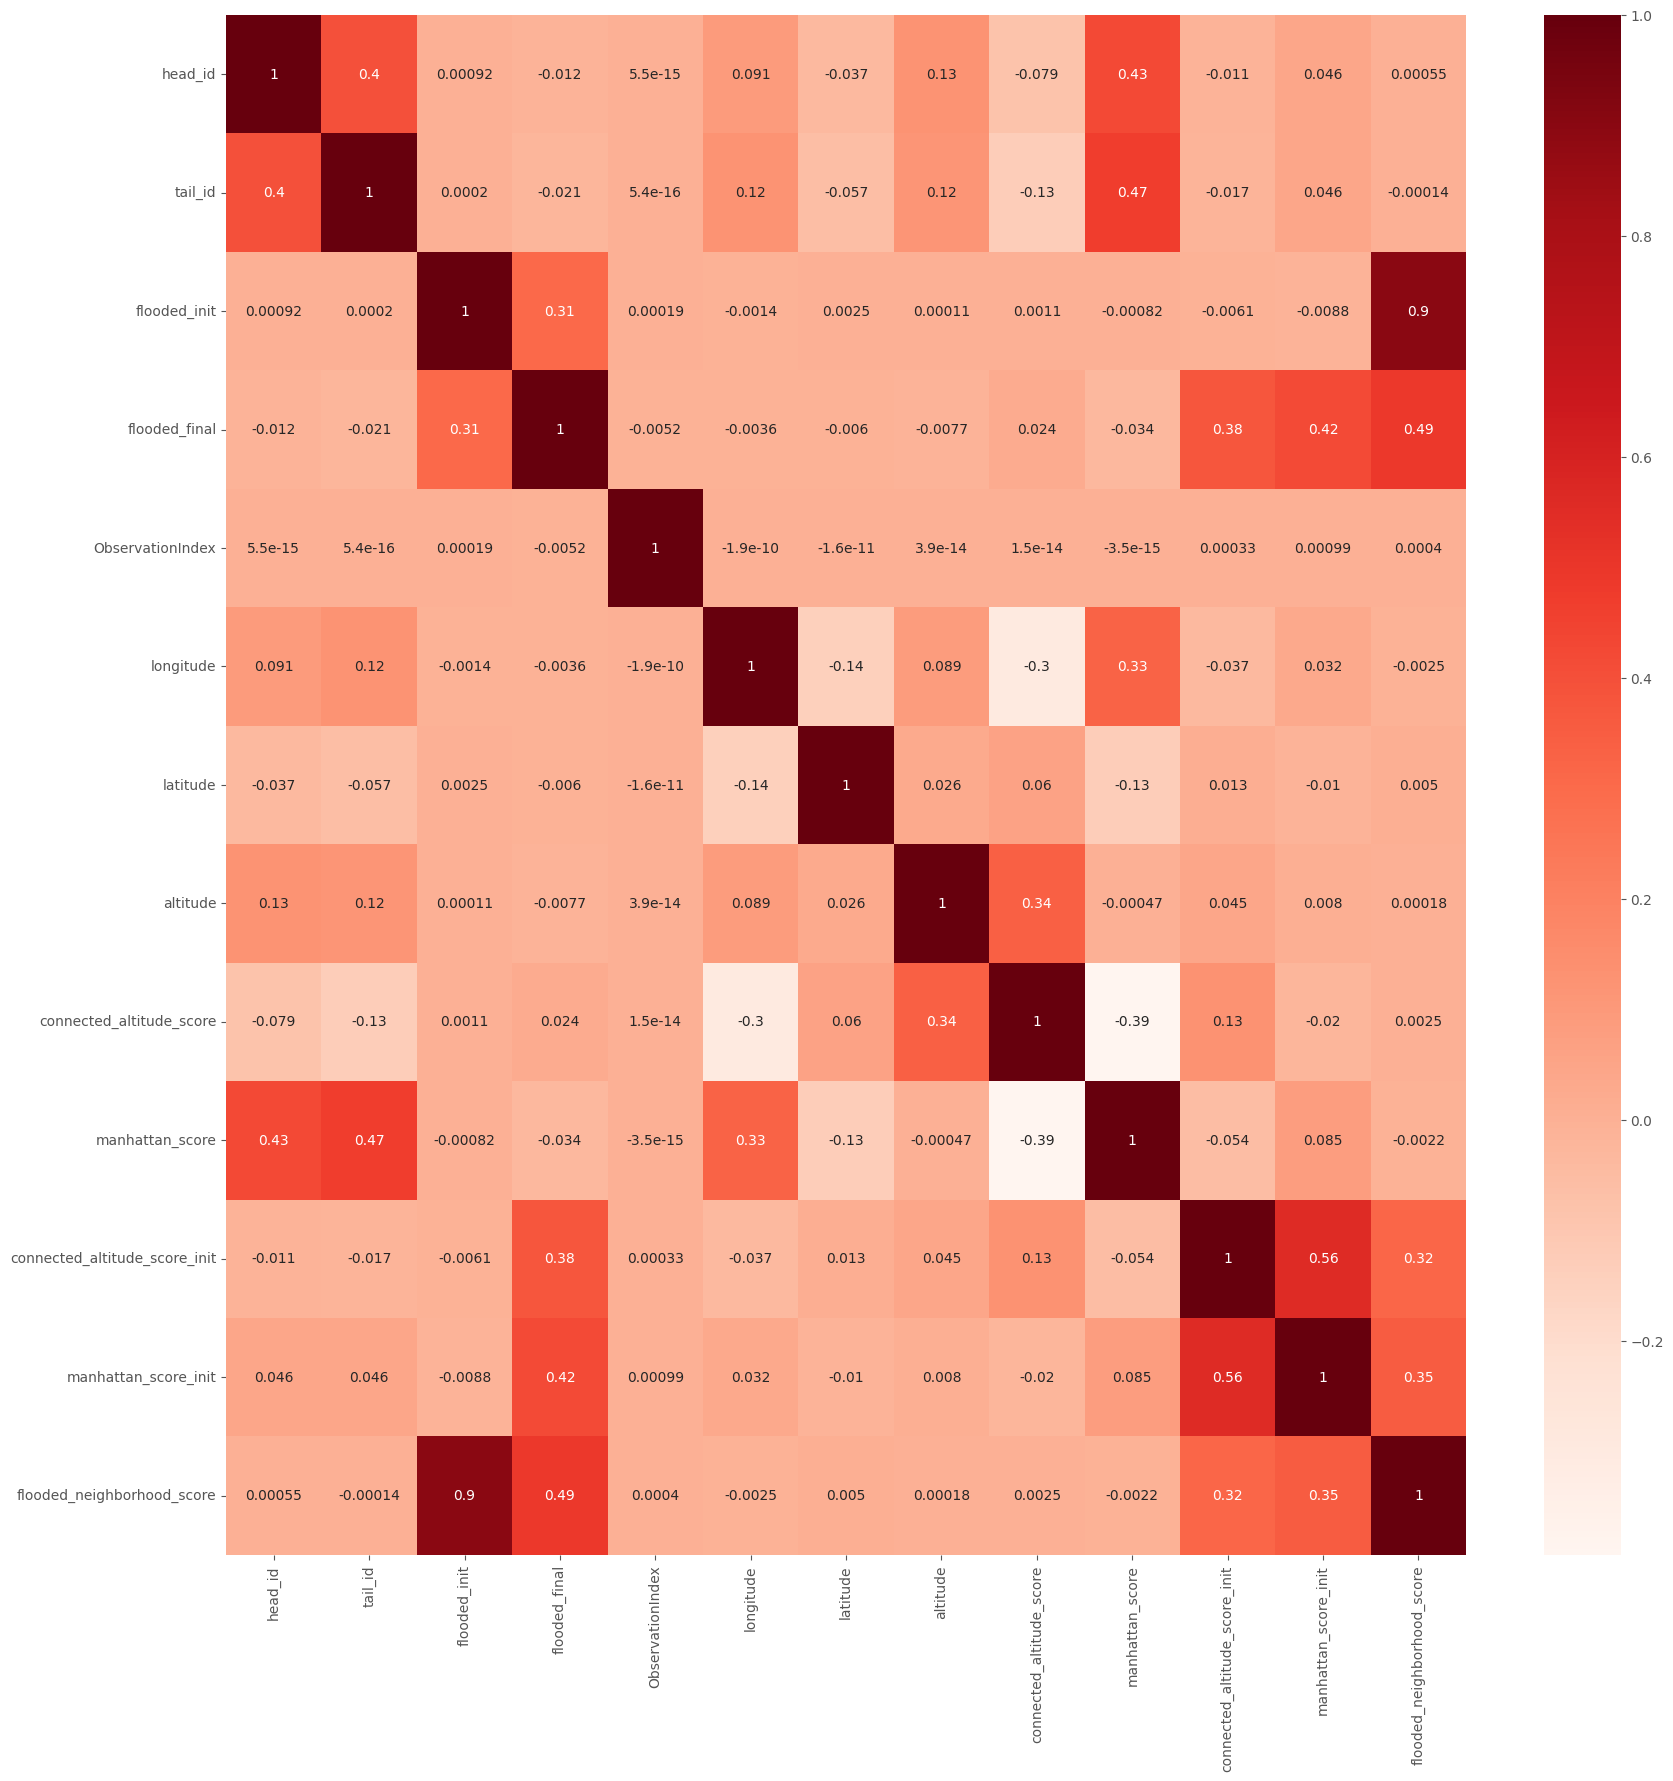

In [192]:
#Correration matrix of the training dataframe with heatmap
corr_matrix = df_training.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

For generalizing purpose, I subtract:
- connected_altitude_score - connected_altitude_score_init (If equal to connected_altitude_score it means that the considered street is not connected with INITIALLY FLOODED roads)
- manhattan_score - manhattan_score_init (If equal to manhattan_score it means that the considered street is not connected with INITIALLY FLOODED roads)

With this subctraction i am reducing the number of columns, keeping connectvity information (both general connectivity and INITIALLY FLOODED connectivity).

In [193]:
#Subctract the connected_altitude_score_init column from the connected_altitude_score column
df_training['connected_altitude_score'] = df_training['connected_altitude_score'] - df_training['connected_altitude_score_init']
df_test['connected_altitude_score'] = df_test['connected_altitude_score'] - df_test['connected_altitude_score_init']

#Drop the connected_altitude_score_init column
df_training = df_training.drop(columns=['connected_altitude_score_init'])
df_test = df_test.drop(columns=['connected_altitude_score_init'])

#Subctract the manhattan_score_init column from the manhattan_score column
df_training['manhattan_score'] = df_training['manhattan_score'] - df_training['manhattan_score_init']
df_test['manhattan_score'] = df_test['manhattan_score'] - df_test['manhattan_score_init']

#Drop the manhattan_score_init column
df_training = df_training.drop(columns=['manhattan_score_init'])
df_test = df_test.drop(columns=['manhattan_score_init'])

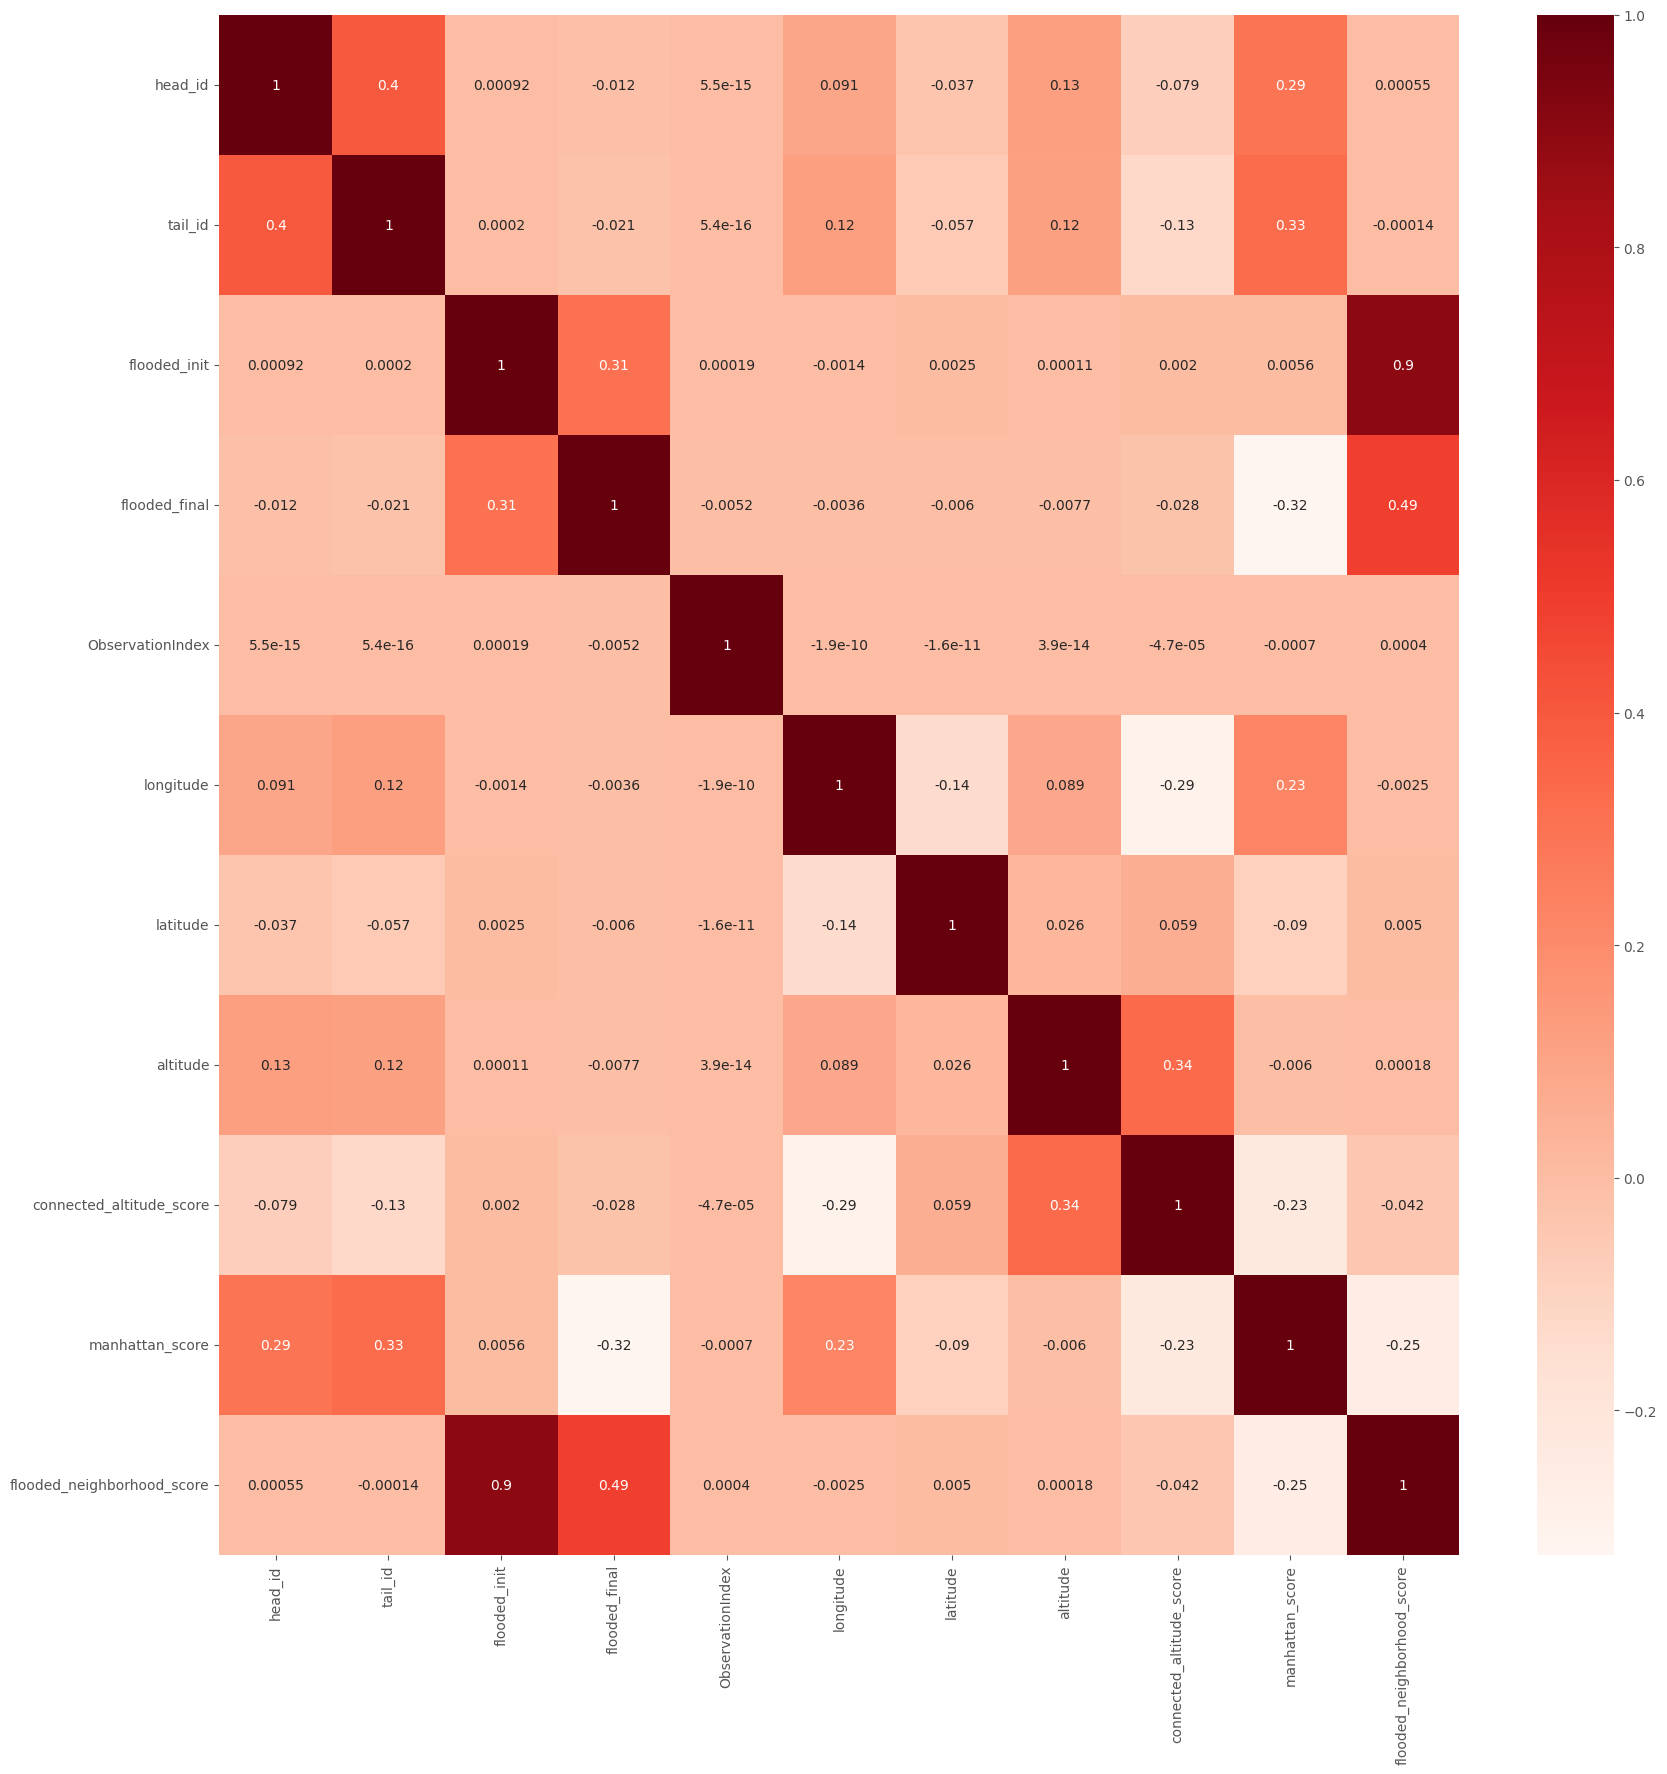

In [194]:
#Correlation matrix of the training dataframe with heatmap
corr_matrix = df_training.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

### Drop head_id, tail_id,flooded_init, longitude, latitude and altitude
- As now i have new columns (more correlated with the target flooded_final) that contain the information about flooded_init, longitude, latitude and altitude, I can drop them.
- Drop head_id and tail_id as they were important for merging, but not correlated and not informative for the target variable. [As they are categorical attributes, I tried using dummies for this 2 columns to improve connectivity information (common head_id or tail_id means connection), but they have 99 and 112 categories respectively-->curse of dimensionality]

In [195]:
#Drop columns for both dataframes (do not for flooded_init,head_id,tail_id of test set because they are needed for the submission and for the order of the rows)
df_training.drop(['flooded_init'], axis=1, inplace=True)

df_training.drop(['longitude'], axis=1, inplace=True)
df_test.drop(['longitude'], axis=1, inplace=True)

df_training.drop(['latitude'], axis=1, inplace=True)
df_test.drop(['latitude'], axis=1, inplace=True)

df_training.drop(['altitude'], axis=1, inplace=True)
df_test.drop(['altitude'], axis=1, inplace=True)

df_training.drop(['head_id'], axis=1, inplace=True)

df_training.drop(['tail_id'], axis=1, inplace=True)

df_training


,flooded_final,ObservationIndex,connected_altitude_score,manhattan_score,flooded_neighborhood_score
0,False,0,226.3,897.021887,0.00
1,False,0,334.0,839.207788,0.00
2,False,0,143.3,931.387768,0.00
3,False,0,124.5,823.892894,0.00
4,False,0,197.6,742.528309,0.00
...,...,...,...,...,...
572995,True,2999,358.8,1044.386423,0.00
572996,False,2999,142.0,1182.965300,0.00
572997,True,2999,118.1,461.290177,0.25
572998,False,2999,282.1,1896.333755,0.00


In [196]:
df_test

,head_id,tail_id,flooded_init,ObservationIndex,connected_altitude_score,manhattan_score,flooded_neighborhood_score
0,151779659,152136099,False,0,145.3,204.021194,0.2
1,151779659,152426116,False,0,298.2,-567.261973,0.2
2,151779659,153066427,True,0,143.3,931.387768,1.0
3,151779763,152437059,False,0,124.5,823.892894,0.0
4,151779763,152541738,False,0,197.6,742.528309,0.0
...,...,...,...,...,...,...,...
38195,153295319,153341528,False,199,358.8,1044.386423,0.0
38196,153444946,153444951,False,199,142.0,1182.965300,0.0
38197,153456725,153456737,False,199,241.0,1406.469761,0.0
38198,1191806314,1191806355,False,199,282.1,1896.333755,0.0


## Second merge
After the merge of the resulting dataframes with respectively train_parameters and test_parameters, I can finally drop ObservationIndex column because it is not informative for the task (low correlation with target variable).

In [197]:
# Merge the training dataframe with the training parameters dataframe based on the ObservationIndex column
merged_training = pd.merge(df_training, training_params, left_on=["ObservationIndex"], right_on=["ObservationIndex"]).sort_values(by=["ObservationIndex"])
df_training = merged_training.reset_index(drop=True)

# Merge the test dataframe with the test parameters dataframe based on the ObservationIndex column
merged_test = pd.merge(df_test, test_params, left_on=["ObservationIndex"], right_on=["ObservationIndex"]).sort_values(by=["ObservationIndex"])
df_test = merged_test.reset_index(drop=True)



#Drop the ObservationIndex column (not for the test set because it is needed for the submission and for the order of the rows)
df_training.drop(['ObservationIndex'], axis=1, inplace=True) #drop the ObservationIndex column for the training dataframe


## Duplicates
Check if there are duplicates in the training dataframe 

In [198]:
duplicates_training = df_training[df_training.duplicated()]  # duplicates in the training dataframe
duplicates_training

,flooded_final,connected_altitude_score,manhattan_score,flooded_neighborhood_score,SurfaceType,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio
58637,False,170.3,899.887514,0.0,D,5,5,0.21,0.18
58640,True,410.5,964.475165,0.0,D,5,5,0.21,0.18
58644,False,267.2,1050.972149,0.0,D,5,5,0.21,0.18
58645,False,196.7,1163.873371,0.0,D,5,5,0.21,0.18
58647,False,156.5,1192.842942,0.0,D,5,5,0.21,0.18
...,...,...,...,...,...,...,...,...,...
572992,False,535.8,1105.705440,0.0,D,3,5,0.25,0.19
572993,False,414.4,786.410821,0.0,D,3,5,0.25,0.19
572996,False,436.4,1068.376068,0.0,D,3,5,0.25,0.19
572998,False,249.9,1103.955842,0.0,D,3,5,0.25,0.19


In [199]:
#Drop duplicates in the training dataframe and reset the index
df_training.drop_duplicates(inplace=True)
df_training.reset_index(drop=True, inplace=True)
df_training


,flooded_final,connected_altitude_score,manhattan_score,flooded_neighborhood_score,SurfaceType,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio
0,False,226.3,897.021887,0.000000,D,5,3,0.11,0.11
1,False,384.1,966.650556,0.000000,D,5,3,0.11,0.11
2,True,367.6,144.130620,0.166667,D,5,3,0.11,0.11
3,False,395.2,832.916875,0.000000,D,5,3,0.11,0.11
4,False,203.4,980.151924,0.000000,D,5,3,0.11,0.11
...,...,...,...,...,...,...,...,...,...
544458,False,148.9,2025.316456,0.000000,D,3,5,0.25,0.19
544459,False,120.3,2061.855670,0.000000,D,3,5,0.25,0.19
544460,True,480.6,190.581950,0.166667,D,3,5,0.25,0.19
544461,True,339.2,791.765637,0.000000,D,3,5,0.25,0.19


## Missing values

In [200]:
# NO NaN values in the training dataframe
df_training.isnull().any()

flooded_final                 False
connected_altitude_score      False
manhattan_score               False
flooded_neighborhood_score    False
SurfaceType                   False
RainfallIntensity             False
init_max_hour                 False
DrainageSystemCapacity        False
GreenSpaceRatio               False
dtype: bool

In [201]:
#Missing values in the column "RainfallIntensity" are encoded with -999
print(df_training["RainfallIntensity"].unique()) #values in the column "RainfallIntensity" training
print(df_test["RainfallIntensity"].unique()) #values in the column "RainfallIntensity" test


print((df_training["RainfallIntensity"] == -999).sum()) # 764 rows with missing values in the column "RainfallIntensity" training 
print((df_test["RainfallIntensity"] == -999).sum()) # 0 rows missing with values in the column "RainfallIntensity" test




[   5    2    4    3 -999]
[4 3 2 5]
764
0


In [202]:
# Drop rows with missing values in the column "RainfallIntensity" training
df_training.drop(df_training[df_training["RainfallIntensity"].isin([-999])].index, inplace=True)
df_training.shape # 544463 rows - 764 rows =  543699 rows


(543699, 9)

## Convert categorical
Use OneHotEncoder over get_dummies in case, you don't have the test set and you don't want to incurr on the problem of don't saving exploded categories (different number of values for the categorical attribute in the training and in the test set).

In this case I have the test and I can verify that the number of categories are the same for training and test, in hence I could also use get_dummies.

Being a "big" dataset, the choice depends only on memory space. 

Surfacetype is the only catgorical attributes.



In [203]:
from sklearn.preprocessing import OneHotEncoder

print(df_training["SurfaceType"].unique()) # values in the column "SurfaceType" training
print(df_test["SurfaceType"].unique()) # values in the column "SurfaceType" test
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore') #sparse=True means that the output will be a sparse matrix so that it will not take too much memory

['D' 'B' 'A' 'C']
['D' 'A' 'C' 'B']


In [204]:
df_training_dummies_Surface = pd.get_dummies(df_training["SurfaceType"],prefix="SurfaceType")
df__training_onehot_Surface = encoder.fit_transform(df_training[["SurfaceType"]])


In [205]:
memory_usage_dummies = df_training_dummies_Surface.memory_usage(deep=True).sum() / (1024 * 1024)  # in megabyte
memory_usage_sparse = (df__training_onehot_Surface.data.nbytes + df__training_onehot_Surface.indptr.nbytes + df__training_onehot_Surface.indices.nbytes) / (1024 * 1024)  # in megabyte

print(f'memory_usage_dummies: {memory_usage_dummies:.2f} MB')
print(f'memory_usage_OneHotEncoding_sparse: {memory_usage_sparse:.2f} MB')

memory_usage_dummies: 6.22 MB
memory_usage_OneHotEncoding_sparse: 8.30 MB


In [206]:
#Let's use get_dummies as it is more memory efficient
df_training_dummies_Surface = pd.get_dummies(df_training["SurfaceType"],prefix="SurfaceType") #get_dummies for the column "SurfaceType" training
df_test_dummies_Surface = pd.get_dummies(df_test["SurfaceType"],prefix="SurfaceType") #get_dummies for the column "SurfaceType" test

df_training = pd.concat([df_training, df_training_dummies_Surface], axis=1) #axis=1 to concatenate along columns dummies and df_training
df_training.drop(columns=["SurfaceType"], inplace=True) #drop the original columns "SurfaceType"

df_test = pd.concat([df_test,df_test_dummies_Surface], axis=1) #axis=1 to concatenate along columns dummies and df_training
df_test.drop(columns=["SurfaceType"], inplace=True) #drop the original column "SurfaceType"


print(df_training.shape) #(9 old columns - 1 drop + 4 surface= 12 columns)
print(df_test.shape) #(8 old columns - 1 drop + 4 surface + head_id + tail_id + ObservationIndex + flooded_init= 15 columns)

df_training


(543699, 12)
(38200, 15)


,flooded_final,connected_altitude_score,manhattan_score,flooded_neighborhood_score,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,SurfaceType_A,SurfaceType_B,SurfaceType_C,SurfaceType_D
0,False,226.3,897.021887,0.000000,5,3,0.11,0.11,False,False,False,True
1,False,384.1,966.650556,0.000000,5,3,0.11,0.11,False,False,False,True
2,True,367.6,144.130620,0.166667,5,3,0.11,0.11,False,False,False,True
3,False,395.2,832.916875,0.000000,5,3,0.11,0.11,False,False,False,True
4,False,203.4,980.151924,0.000000,5,3,0.11,0.11,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
544458,False,148.9,2025.316456,0.000000,3,5,0.25,0.19,False,False,False,True
544459,False,120.3,2061.855670,0.000000,3,5,0.25,0.19,False,False,False,True
544460,True,480.6,190.581950,0.166667,3,5,0.25,0.19,False,False,False,True
544461,True,339.2,791.765637,0.000000,3,5,0.25,0.19,False,False,False,True


## Data normalization
Normalization for REAL numerical number (not the encoded with dummies ones). 

I choose normalization with range [0,1]

In [207]:
df_training.describe()

,connected_altitude_score,manhattan_score,flooded_neighborhood_score,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio
count,543699.000000,543699.000000,543699.000000,543699.000000,543699.000000,543699.000000,543699.000000
mean,211.697715,1121.795449,0.037757,3.501093,4.010305,0.198614,0.200701
std,129.259565,595.681723,0.150711,1.116163,0.815951,0.057257,0.059122
min,0.000000,-7384.403036,0.000000,2.000000,3.000000,0.100000,0.100000
25%,123.200000,888.494003,0.000000,2.000000,3.000000,0.150000,0.150000
50%,181.300000,1076.812635,0.000000,4.000000,4.000000,0.200000,0.200000
75%,270.200000,1369.394043,0.000000,4.000000,5.000000,0.250000,0.250000
max,713.400000,3807.106599,1.666667,5.000000,5.000000,0.300000,0.300000


<Axes: >

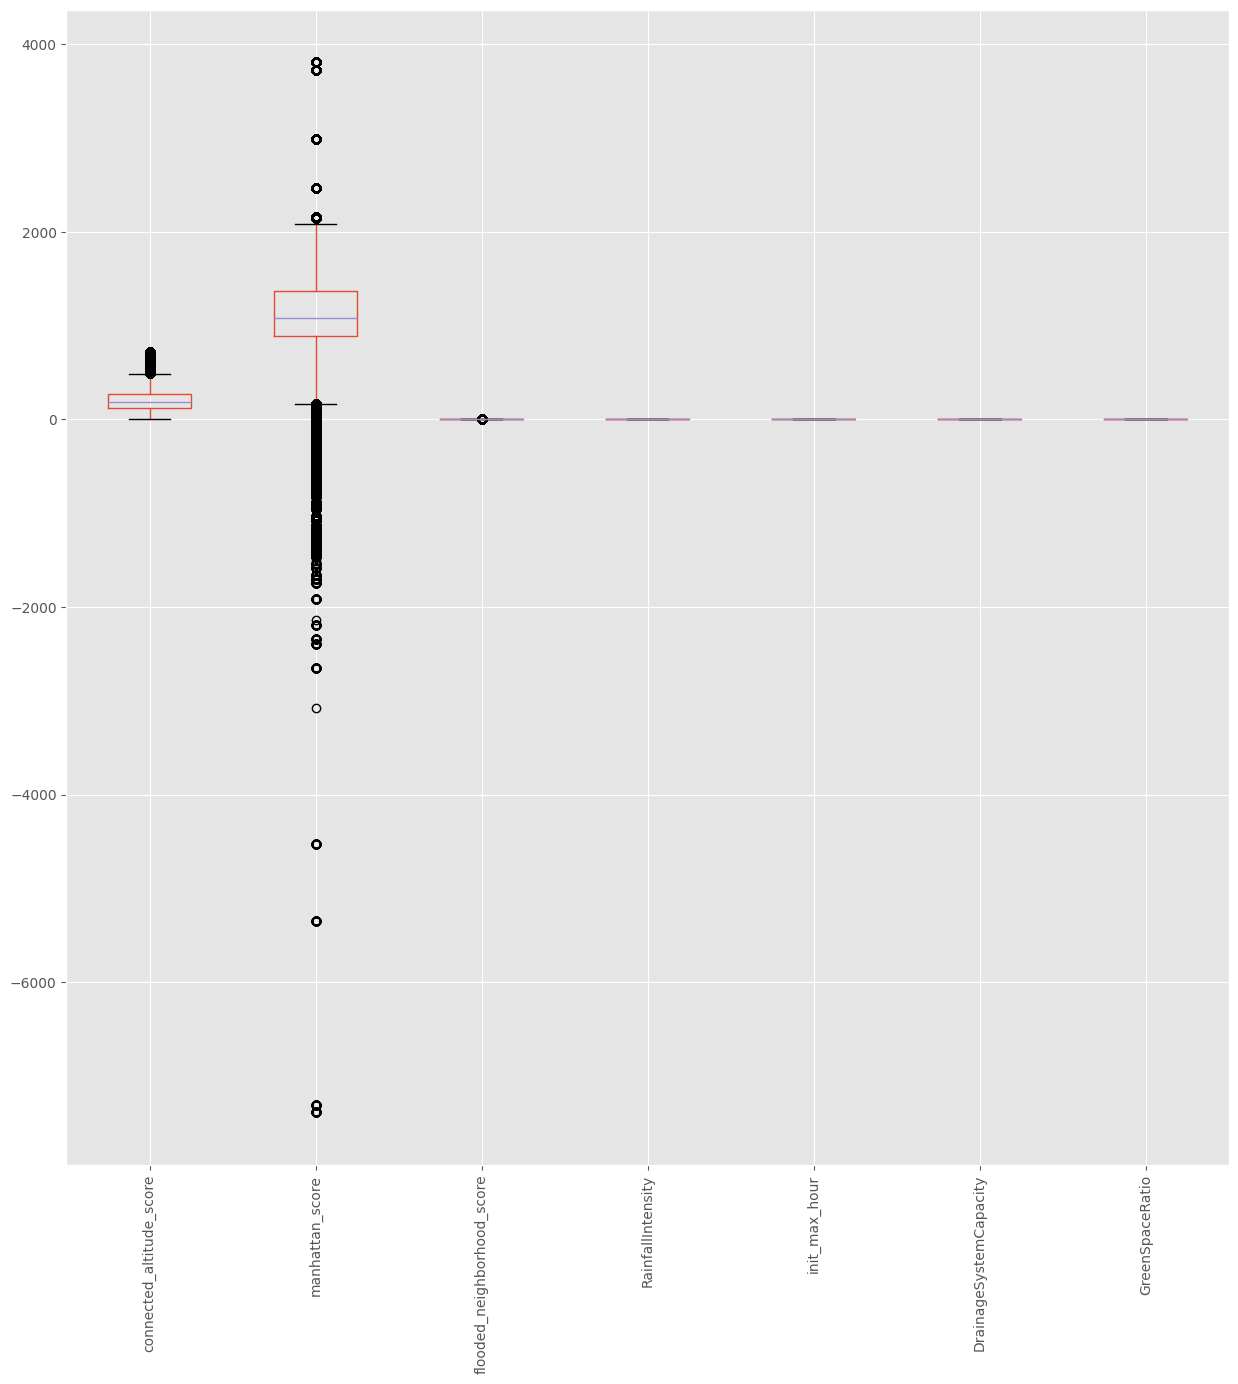

In [208]:
# Boxplot for the numerical columns before normalization
%matplotlib inline
num_cols = ["connected_altitude_score","manhattan_score","flooded_neighborhood_score","RainfallIntensity","init_max_hour","DrainageSystemCapacity","GreenSpaceRatio"]

df_training[num_cols].boxplot(figsize=(15,15),rot=90)

In [209]:
#Apply the transformation to the numerical columns of the training and test dataframes
from sklearn.preprocessing import MinMaxScaler


minmax_scaler = MinMaxScaler(copy=False, feature_range=(0, 1))

# Addestra il MinMaxScaler sulle colonne numeriche del DataFrame di training
minmax_scaler.fit(df_training[num_cols])

# Applica la trasformazione alle colonne numeriche nei diversi DataFrame
df_training[num_cols] = minmax_scaler.transform(df_training[num_cols])
df_test[num_cols] = minmax_scaler.transform(df_test[num_cols])


<Axes: >

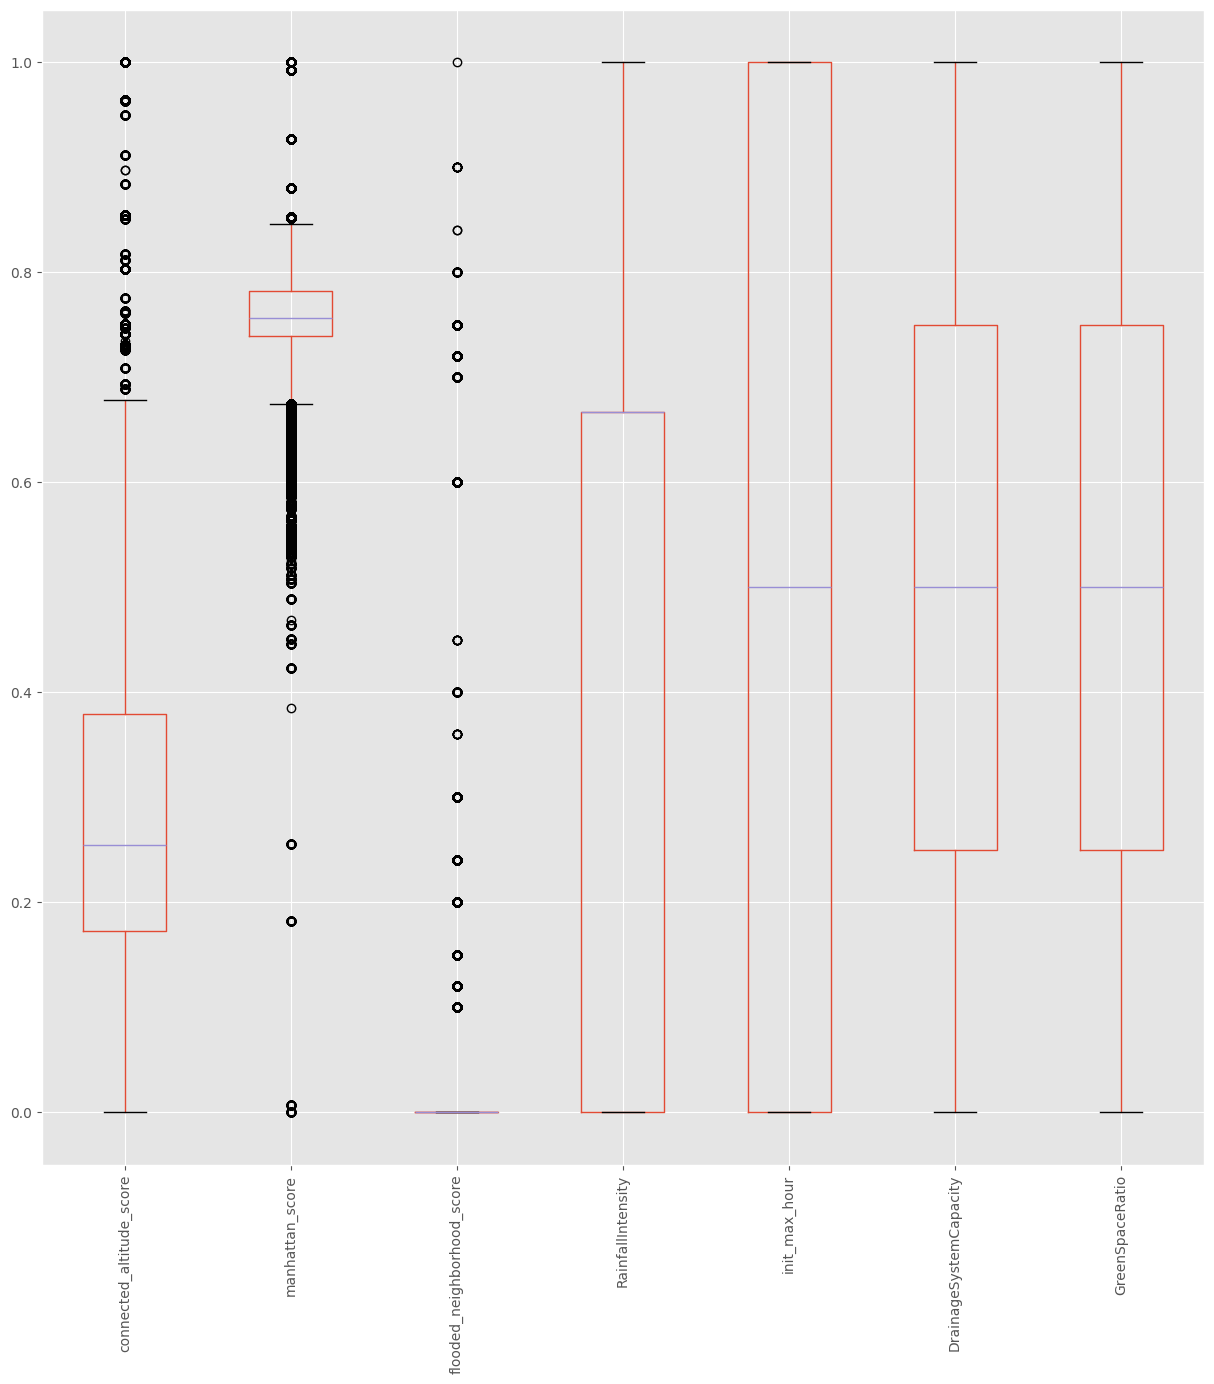

In [210]:
#Boxplot for the numerical columns after normalization
df_training[num_cols].boxplot(figsize=(15,15),rot=90)

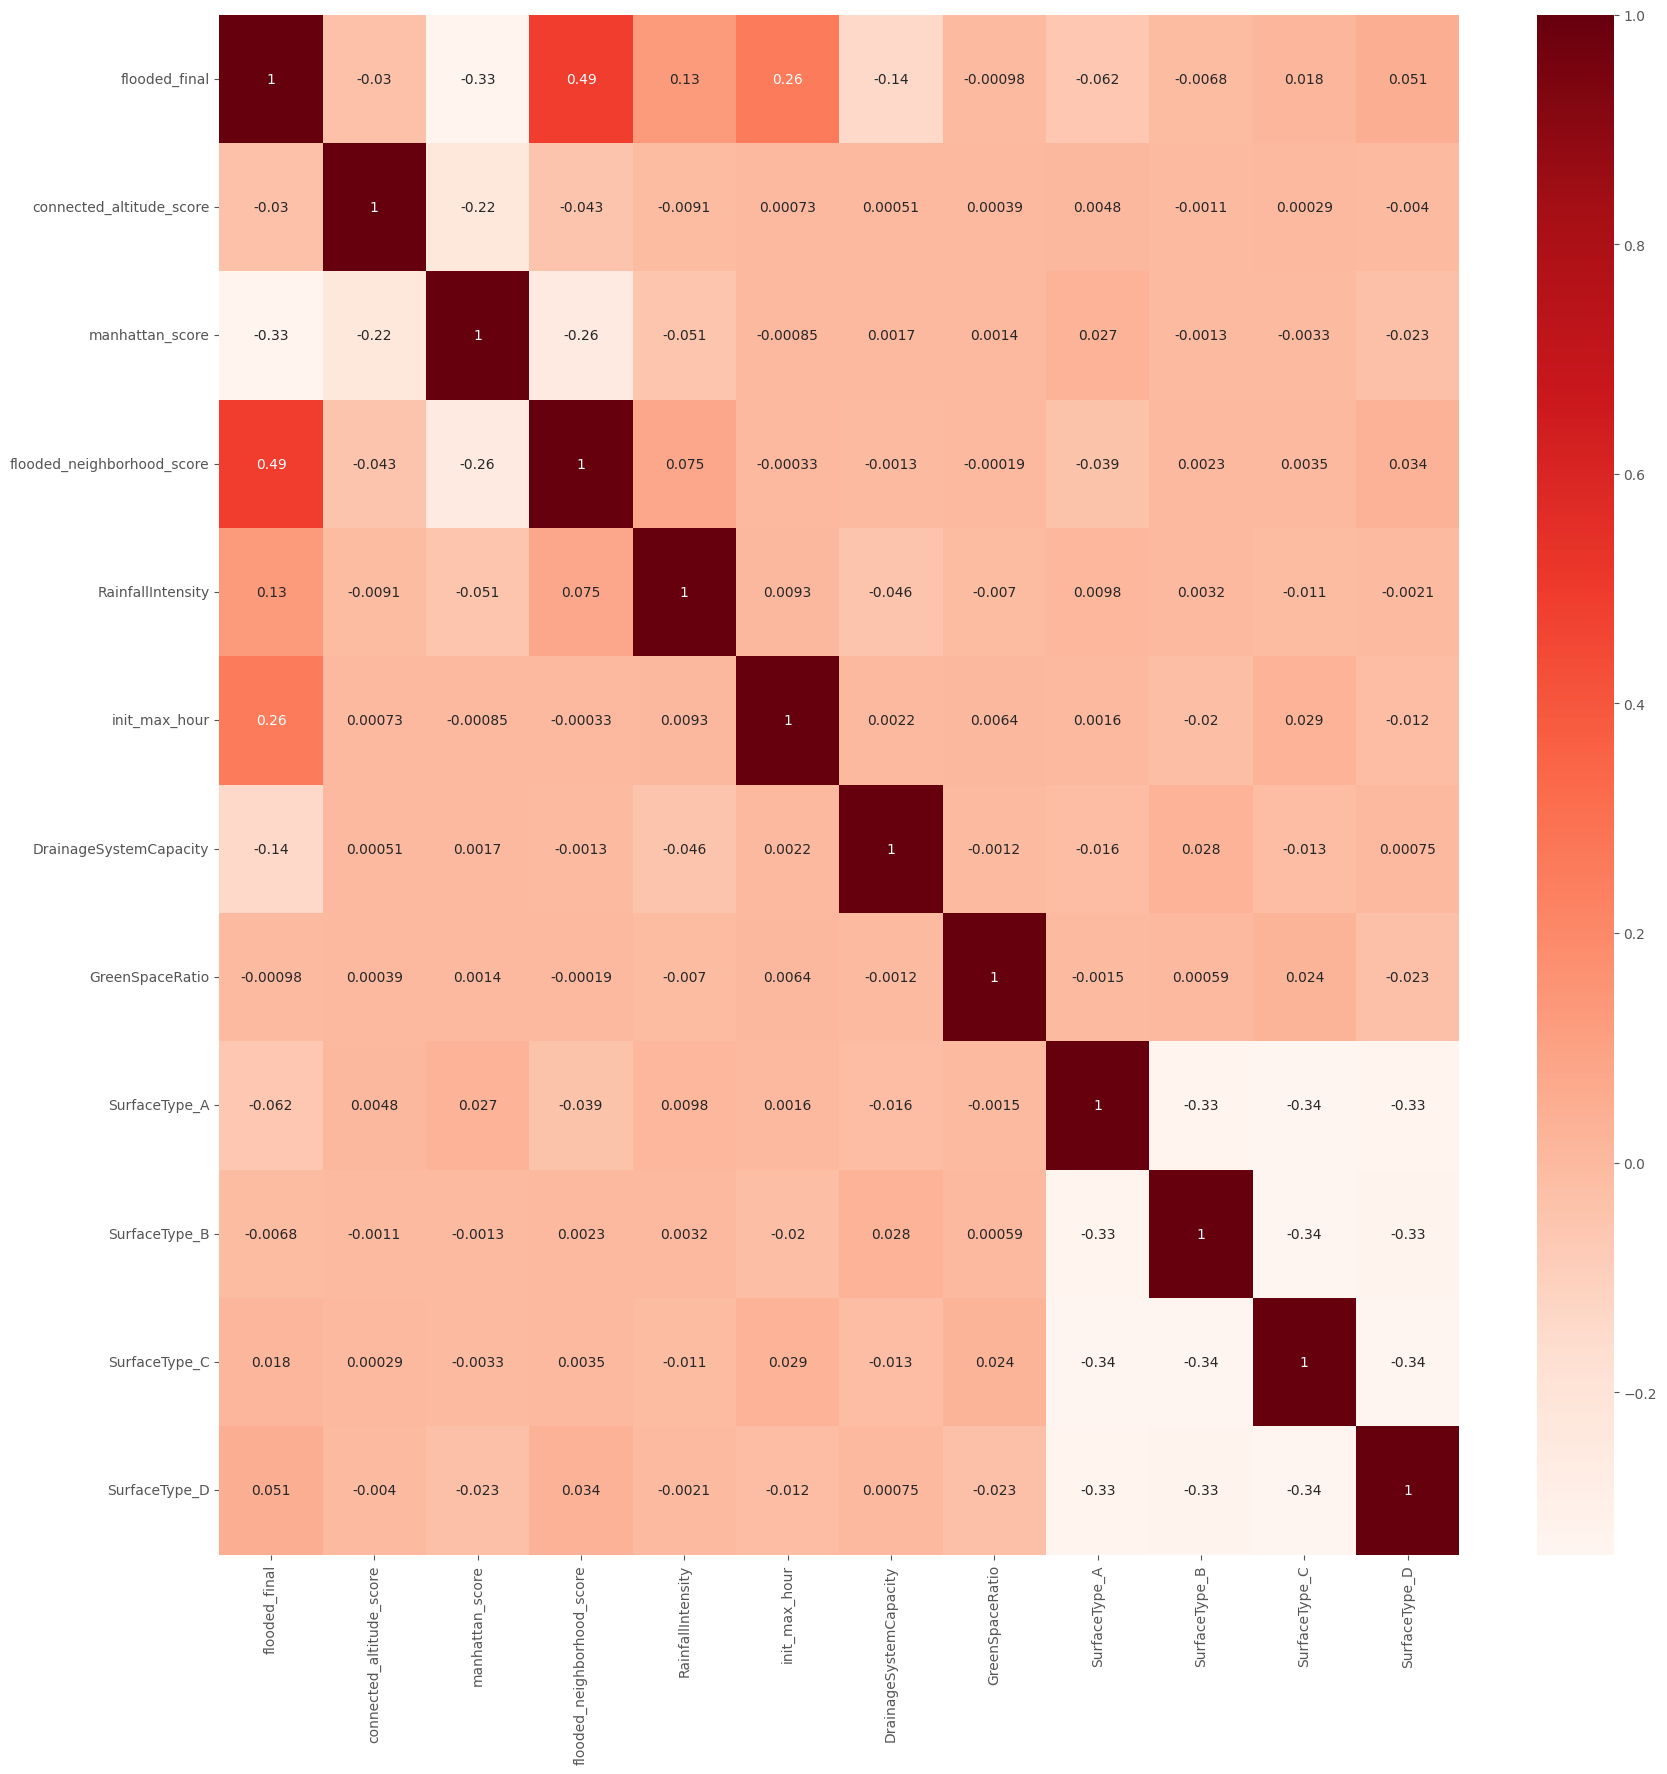

In [211]:
#Correlation matrix of the training dataframe with heatmap
corr_matrix = df_training.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [212]:
#Drop GreenSpaceRatio column for both dataframes because is low correlated with target variable
df_training = df_training.drop(['GreenSpaceRatio'], axis=1)
df_test = df_test.drop(['GreenSpaceRatio'], axis=1)

#Drop duplicates in the training dataframe and reset the index
df_training.drop_duplicates(inplace=True)
df_training.reset_index(drop=True, inplace=True)
df_training


,flooded_final,connected_altitude_score,manhattan_score,flooded_neighborhood_score,RainfallIntensity,init_max_hour,DrainageSystemCapacity,SurfaceType_A,SurfaceType_B,SurfaceType_C,SurfaceType_D
0,False,0.317213,0.739974,0.00,1.000000,0.0,0.05,False,False,False,True
1,False,0.538408,0.746195,0.00,1.000000,0.0,0.05,False,False,False,True
2,True,0.515279,0.672700,0.10,1.000000,0.0,0.05,False,False,False,True
3,False,0.553967,0.734246,0.00,1.000000,0.0,0.05,False,False,False,True
4,False,0.285114,0.747402,0.00,1.000000,0.0,0.05,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
260683,True,0.522428,0.731111,0.60,0.333333,1.0,0.75,False,False,False,True
260684,True,0.760863,0.675537,0.12,0.333333,1.0,0.75,False,False,False,True
260685,True,0.673675,0.676851,0.10,0.333333,1.0,0.75,False,False,False,True
260686,True,0.475470,0.730569,0.00,0.333333,1.0,0.75,False,False,False,True


## Balancing dataset
After modifying and cleaning the training dataframe, I can check if it is imbalanced or not.

Models trained on imbalanced datasets tends to have difficulty in predicting the minority class.

In this case, if imbalanced, downsample the majority class to reduce dimensionality.

flooded_final
False    181829
True      78859
dtype: int64


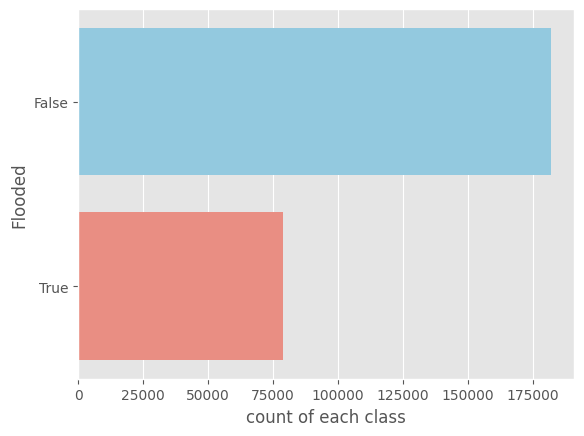

In [213]:
#Print class freq. through pandas 
print(df_training.groupby('flooded_final').size()) 


%matplotlib inline
plt.style.use('ggplot')

#Visualize Class Counts
sns.countplot(y='flooded_final', hue='flooded_final', data=df_training, palette=["skyblue", "salmon"], legend=False)
plt.xlabel("count of each class")
plt.ylabel("Flooded")
plt.show()

In [214]:
# Separate majority and minority classes
df_majority = df_training[df_training.flooded_final==0]
df_minority = df_training[df_training.flooded_final==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample with replacement because the number of rows is small and would not be enough to upsample without replacement
                                 n_samples=len(df_minority),     # to match majority class
                                 random_state=123) # reproducible results


df_downsampled = pd.concat([df_majority_downsampled, df_minority]) # Combine minority class with downsampled majority class

df_downsampled["flooded_final"].value_counts() 

flooded_final
False    78859
True     78859
Name: count, dtype: int64

In [215]:
df_downsampled

,flooded_final,connected_altitude_score,manhattan_score,flooded_neighborhood_score,RainfallIntensity,init_max_hour,DrainageSystemCapacity,SurfaceType_A,SurfaceType_B,SurfaceType_C,SurfaceType_D
75032,False,0.107653,0.826009,0.00,0.333333,0.0,0.40,False,False,True,False
18806,False,0.114522,0.769297,0.00,0.333333,0.5,0.90,False,False,True,False
59131,False,0.237735,0.737134,0.00,0.000000,1.0,0.70,False,False,False,True
237153,False,0.449537,0.779119,0.00,0.333333,0.5,0.25,False,False,False,True
181321,False,0.208719,0.840791,0.00,1.000000,0.5,0.10,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
260683,True,0.522428,0.731111,0.60,0.333333,1.0,0.75,False,False,False,True
260684,True,0.760863,0.675537,0.12,0.333333,1.0,0.75,False,False,False,True
260685,True,0.673675,0.676851,0.10,0.333333,1.0,0.75,False,False,False,True
260686,True,0.475470,0.730569,0.00,0.333333,1.0,0.75,False,False,False,True


## Distributions Analysis
Following subplots show distributions for:
- test set (without target variable)
- balanced train set, divided in:
    - 50% flooded
    - 50% Not flooded

The distributions for the two dataframes are almost equal (good), except for manhattan score because the test set is surely not balanced and so the values lower than 0.7 have "less counts" in respect to higher values (a balanced test set would be similar to the training set case)

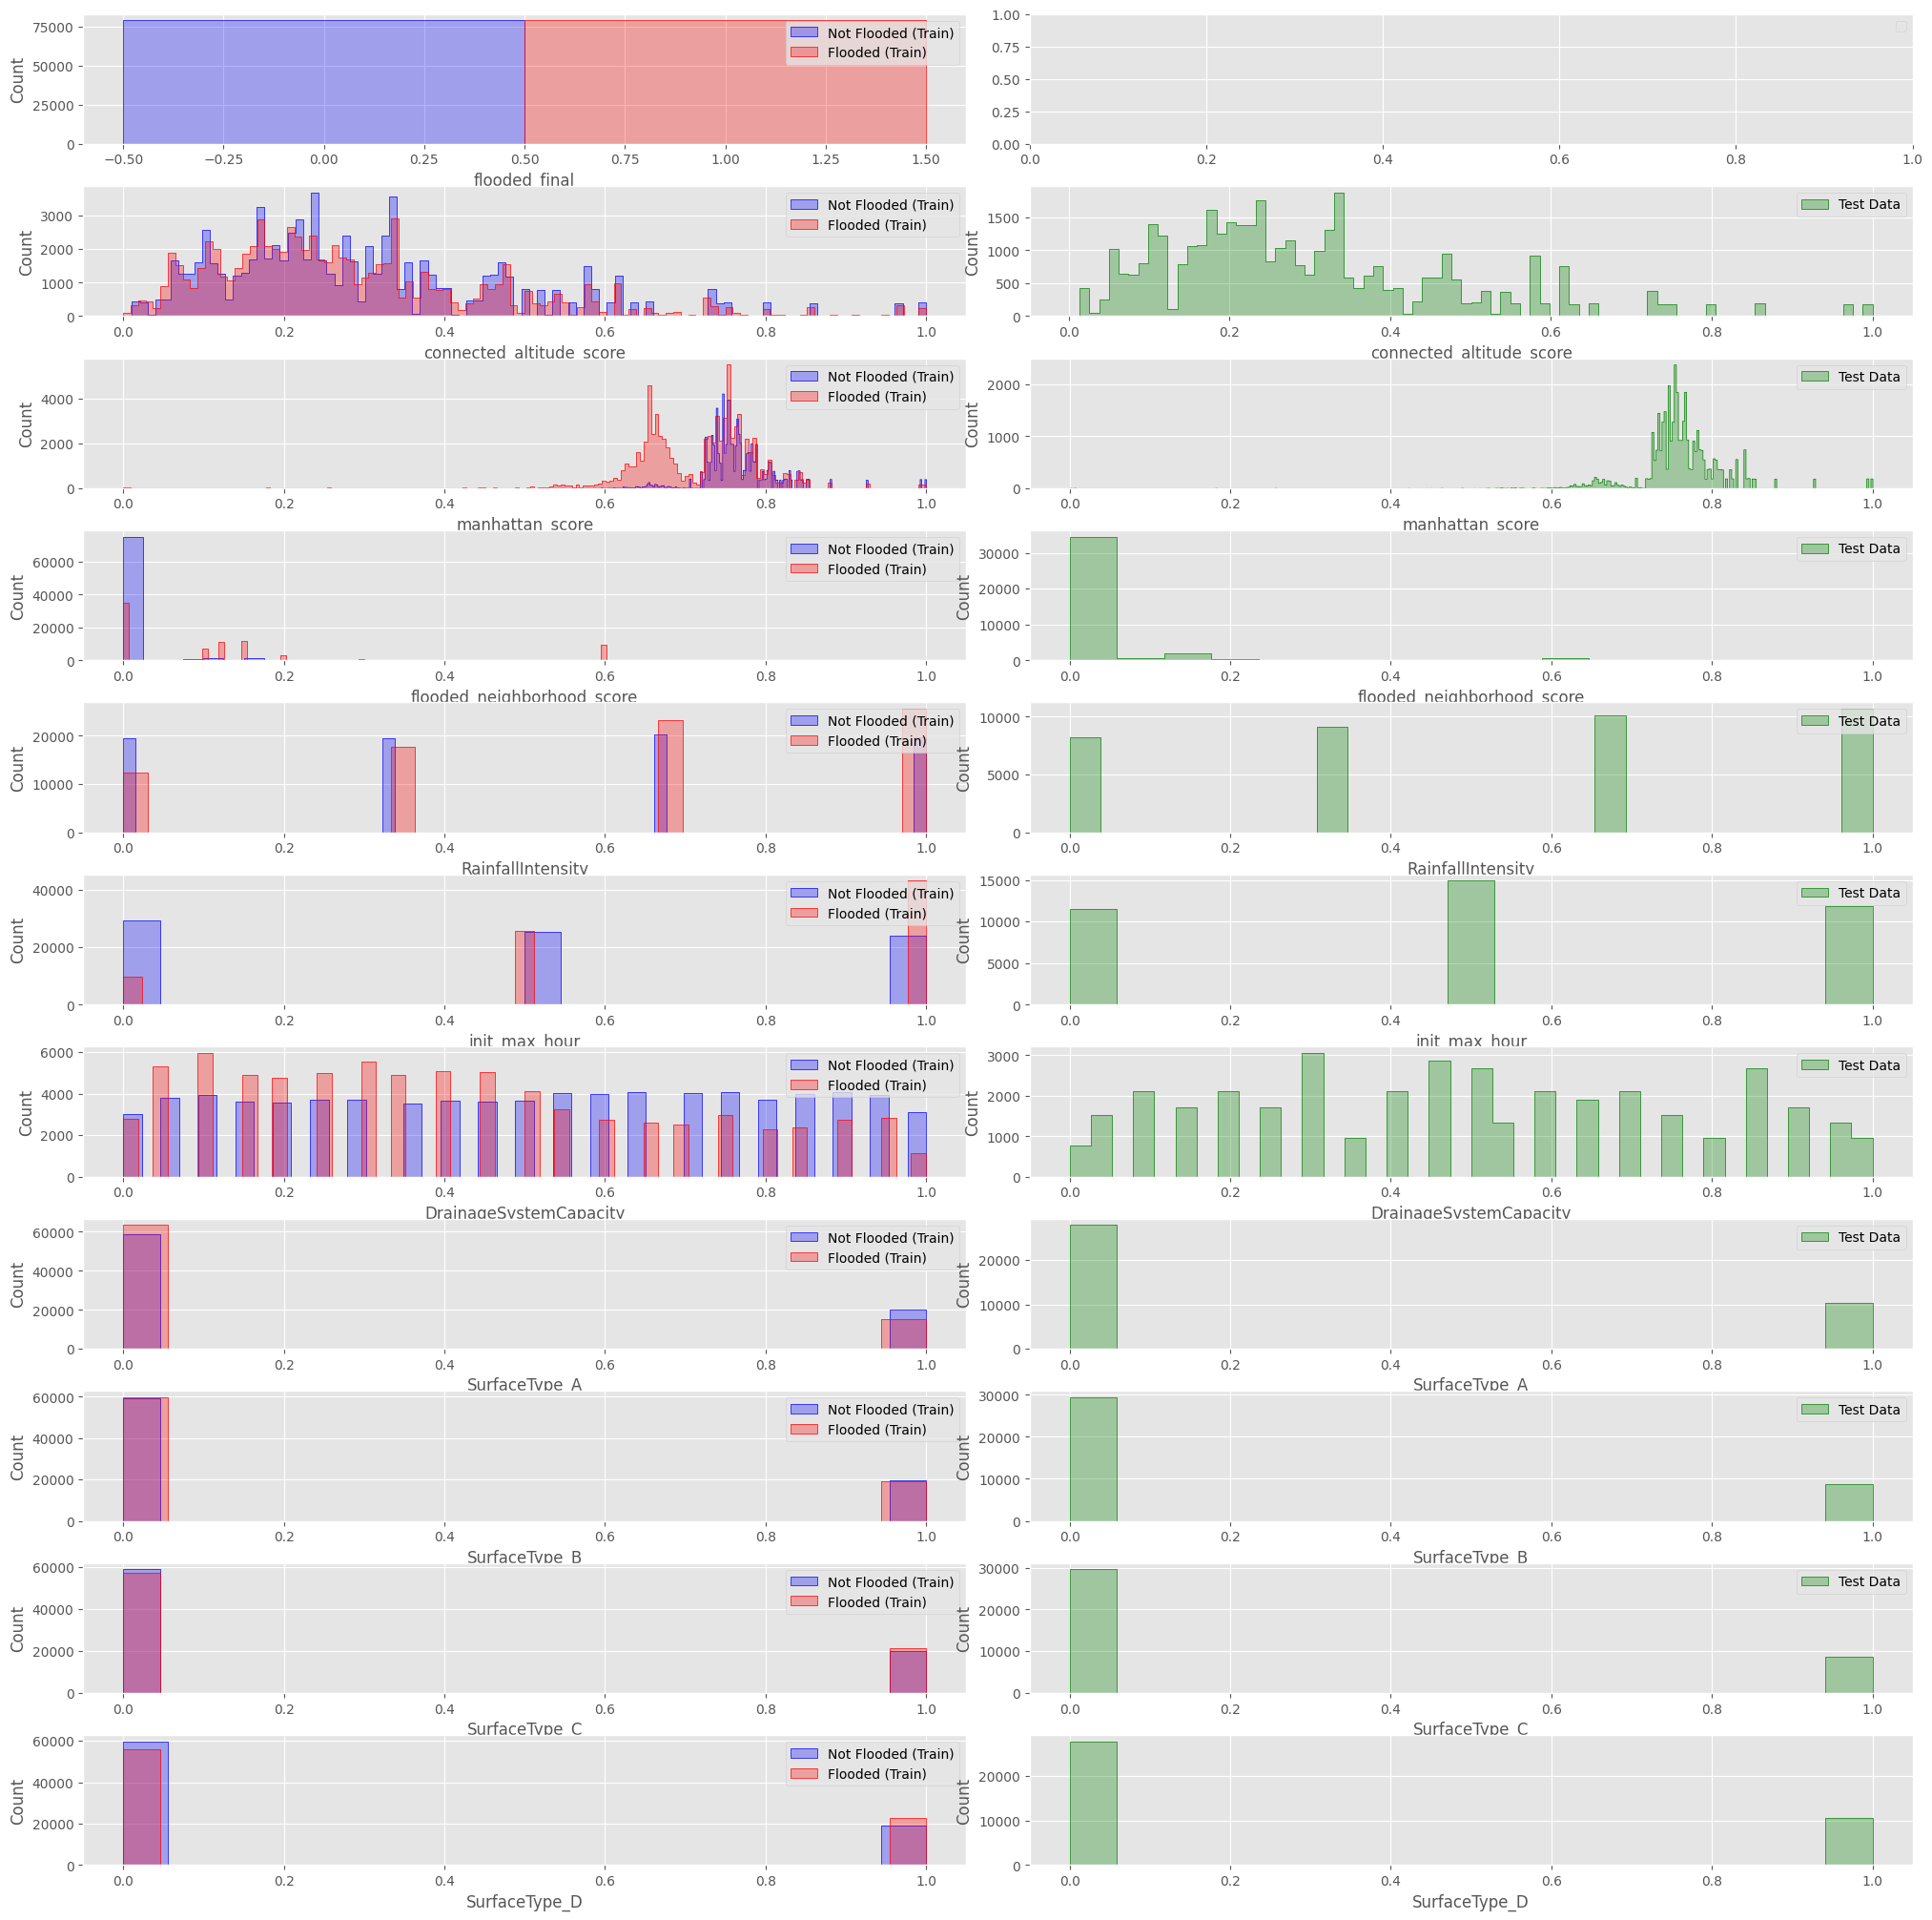

In [216]:
X = df_downsampled

# Plot histograms for each variable in the training set
fig, axes = plt.subplots(ncols=2, nrows=len(X.columns), figsize=(20, 20))
fig.tight_layout()

for i, col in enumerate(X.columns):
    # Plot in the first column for the training set
    sns.histplot(X[X['flooded_final'] == False][col], color="blue", element="step", ax=axes[i, 0], alpha=0.3)
    sns.histplot(X[X['flooded_final'] == True][col], color="red", element="step", ax=axes[i, 0], alpha=0.3)
    axes[i, 0].legend(labels=['Not Flooded (Train)', 'Flooded (Train)'])

# Plot histograms for each variable in the test set
excluded_columns = ["head_id", "tail_id", "ObservationIndex","flooded_init"]
included_columns = [col for col in df_test.columns if col not in excluded_columns]

for i, col in enumerate(included_columns):
    # Plot in the second column for the test set
    sns.histplot(df_test[col], color="green", element="step", ax=axes[i+1, 1], alpha=0.3)
    axes[i, 1].legend(labels=['Test Data'])

plt.show()

In [217]:
X.describe()


,connected_altitude_score,manhattan_score,flooded_neighborhood_score,RainfallIntensity,init_max_hour,DrainageSystemCapacity
count,157718.000000,157718.000000,157718.000000,157718.000000,157718.000000,157718.000000
mean,0.290416,0.739900,0.071863,0.549206,0.589283,0.462042
std,0.179140,0.067280,0.152934,0.366095,0.401182,0.291943
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.168209,0.719391,0.000000,0.333333,0.500000,0.200000
50%,0.250631,0.750647,0.000000,0.666667,0.500000,0.450000
75%,0.374544,0.774635,0.120000,1.000000,1.000000,0.700000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


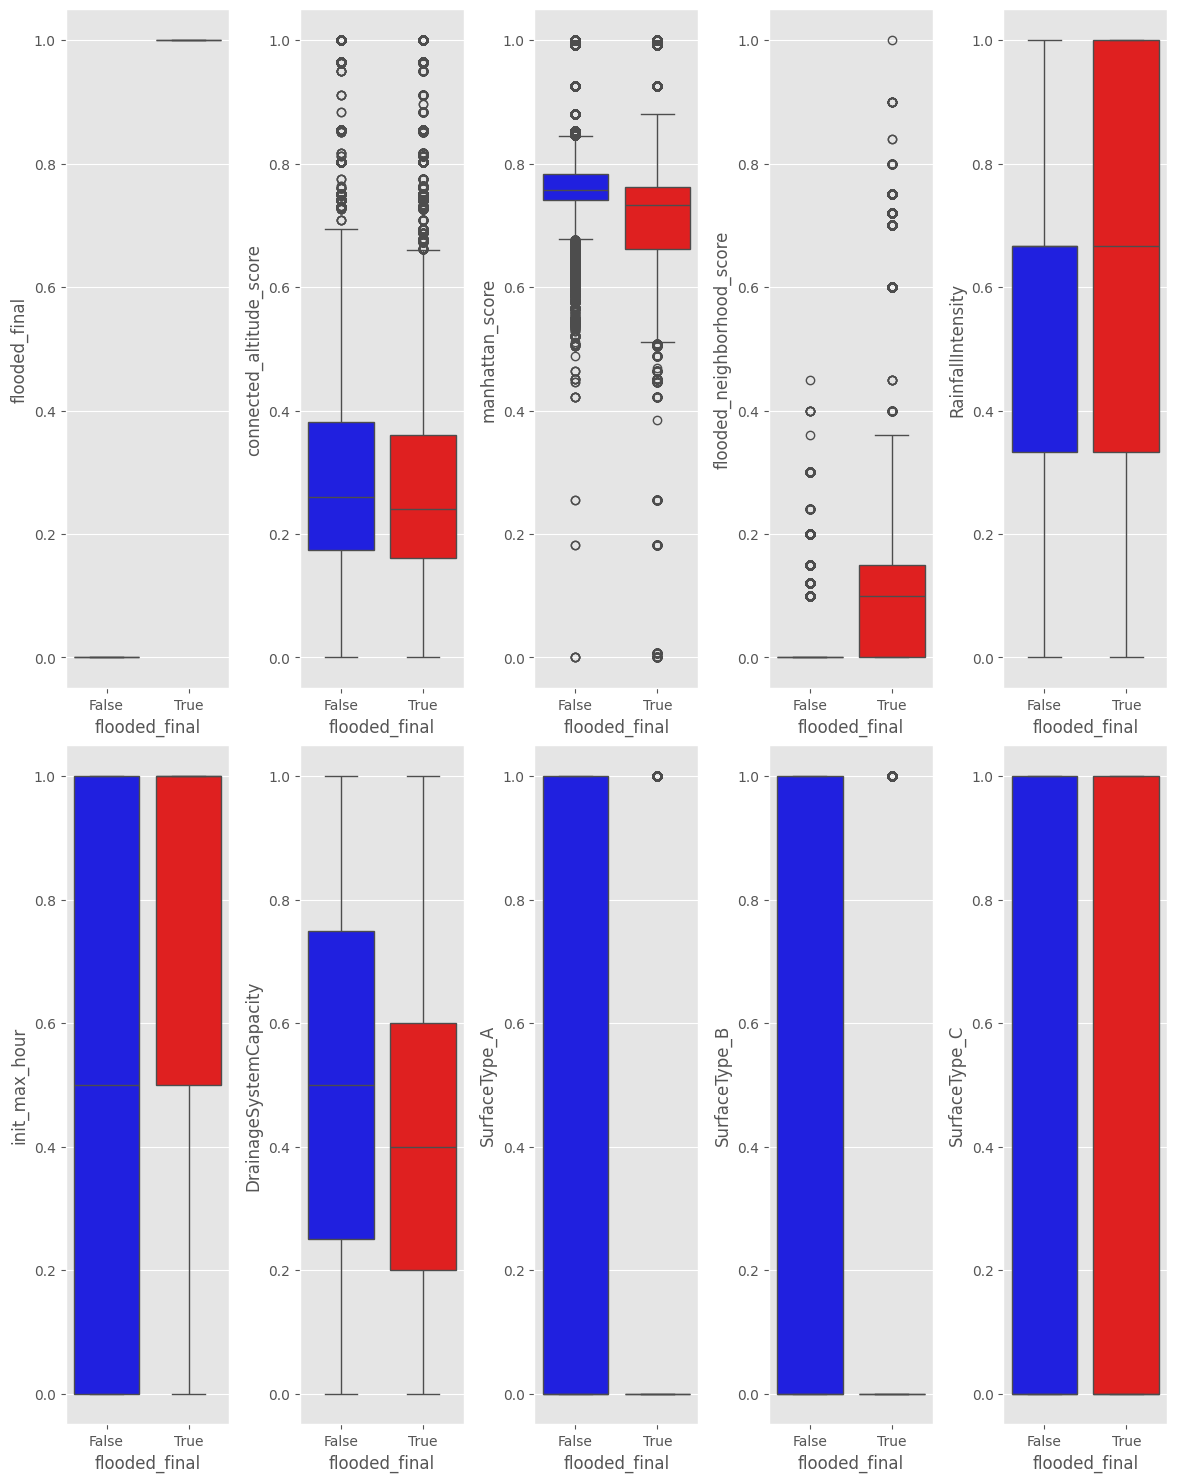

In [218]:
# Boxplot divided by target variable
%matplotlib inline
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12,15))
fig.tight_layout(pad=2)
for i, col in enumerate(X.columns[:-1]):
    sns.boxplot(y=col, x="flooded_final", hue="flooded_final", data=X, orient='v', palette={0: 'blue', 1: 'red'},ax=axes[int(i/5), i%5], legend=False)


## Training and validation
From now on, i will try various models using my final df_training downsampled called X for training and validation.

I split X in training and validation (0.85 and 0.15 respectively), and I use crossvalidation (3 folds) for hyperparameter search.

The models considered are:
- KNN
- Tree
- Rndom Forest
- AdaBoost
- Naive Bayes
- Logistic regression
- Support vector machines
- Multi Layer perceptron
- Gradient Boost

The chosen model is the one with best f1_score on test (notice that in order to avoid overfitting the difference between f1_train and f1_validation should not be higher than 0,03).

In [219]:
#Prepare data for hyperparameter tuning
y = X["flooded_final"] #target variable
X.drop(["flooded_final"], axis=1, inplace=True) #data without target variable 


#SPLIT DATA INTO TRAIN AND VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.15, 
                                                    stratify=y, #preserve target propotions 
                                                    random_state= 321) #fix random seed for replicability

print(X_train.shape, X_test.shape)

(134060, 10) (23658, 10)


In [220]:
# function that performs automatically gridsearch
def hyperp_search(classifier, parameters,X_train,y_train,X_test,y_test):
    #cv=3 cross validation with 3 split
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))
    
    best_model = gs.best_estimator_ 
    best_param=gs.best_params_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    f1_train=f1_score(y_train, y_pred_train)
    prec_train=precision_score(y_train, y_pred_train)
    f1_test=f1_score(y_test, y_pred)
    prec_test=precision_score(y_test, y_pred)
    recall_train=recall_score(y_train, y_pred_train)
    recall_test=recall_score(y_test, y_pred)
    
    print("f1         train %.3f   test %.3f" % (f1_train, f1_test )) 
    print("precision  train %.3f   test %.3f" % (prec_train, prec_test )) 
    print("recall  train %.3f   test %.3f" % (recall_train, recall_test )) 
    print("")
    print(confusion_matrix(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Reds")
    print(classification_report(y_test, y_pred))
    matrix = [[f1_train,f1_test],[prec_train,prec_test]]
    return(best_model,best_param,matrix)


# function that performs roc
def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 
    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.2f' % auc)
    return (auc,fpr, tpr)

#Total evaluation
def total(classifier, parameters,X_train,y_train,X_test,y_test):
    best_model,best_param,matrix=hyperp_search(classifier, parameters,X_train,y_train,X_test,y_test)
    auc,fpr,tpr = roc(best_model,X_train,y_train,X_test,y_test)
    return (matrix,auc,fpr, tpr,best_model,best_param)

f1_train: 0.805122 using {'metric': 'manhattan', 'n_neighbors': 49, 'weights': 'uniform'}
f1         train 0.821   test 0.807
precision  train 0.812   test 0.797
recall  train 0.830   test 0.818

[[9358 2471]
 [2153 9676]]
              precision    recall  f1-score   support

       False       0.81      0.79      0.80     11829
        True       0.80      0.82      0.81     11829

    accuracy                           0.80     23658
   macro avg       0.80      0.80      0.80     23658
weighted avg       0.80      0.80      0.80     23658



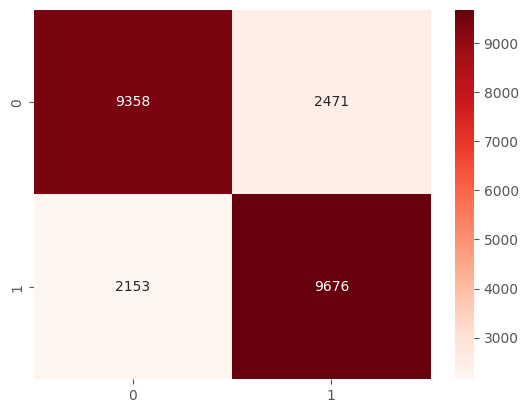

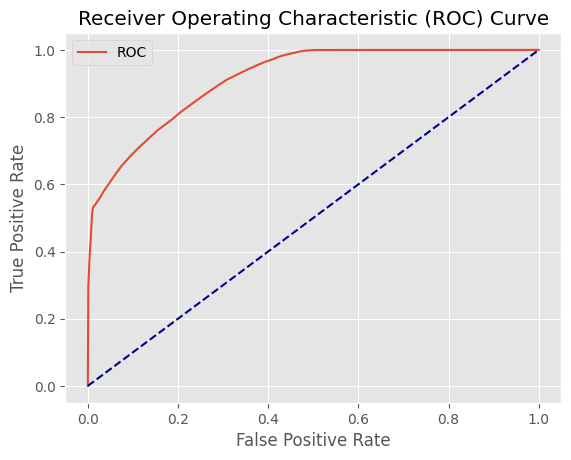

AUC: 0.91


In [221]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()

parameters = {'n_neighbors':np.arange(30,70,1),'weights':['uniform','distance'],'metric':['manhattan','euclidean']}

matrix_KNN,auc_KNN,fpr_KNN, tpr_KNN,best_model_KNN,best_param_KNN=total(classifier,parameters,X_train,y_train,X_test,y_test)

f1_train: 0.808115 using {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 17}
f1         train 0.813   test 0.811
precision  train 0.796   test 0.795
recall  train 0.830   test 0.828

[[9300 2529]
 [2036 9793]]
              precision    recall  f1-score   support

       False       0.82      0.79      0.80     11829
        True       0.79      0.83      0.81     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



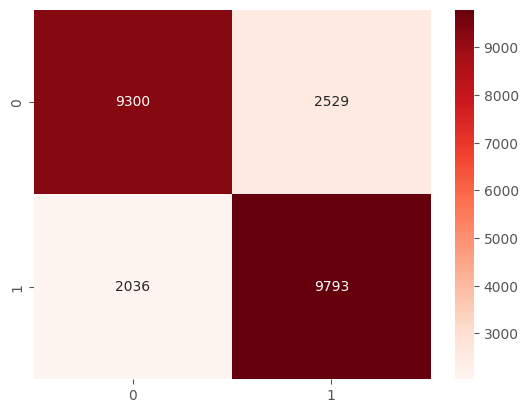

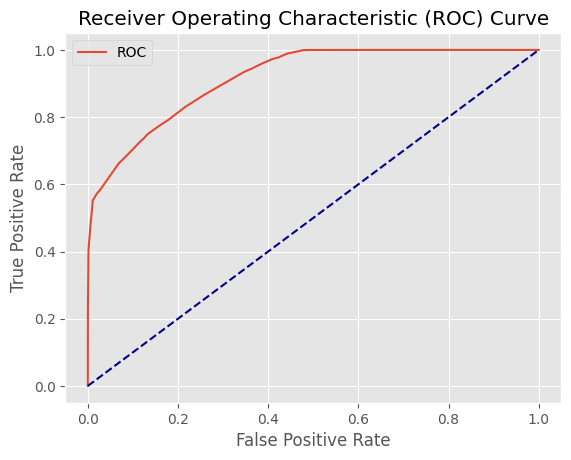

AUC: 0.92


In [222]:
#Tree
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()

parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [4,5,6,7,8,9,10,11],
              'min_samples_split': [16,17,18,19,20,21],
              'min_samples_leaf': [3,4,5,6,7,8]}

matrix_tree,auc_tree,fpr_tree, tpr_tree,best_model_tree,best_param_tree=total(classifier,parameters,X_train,y_train,X_test,y_test)

f1_train: 0.805479 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 20}
f1         train 0.807   test 0.801
precision  train 0.839   test 0.830
recall  train 0.778   test 0.774

[[9954 1875]
 [2672 9157]]
              precision    recall  f1-score   support

       False       0.79      0.84      0.81     11829
        True       0.83      0.77      0.80     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



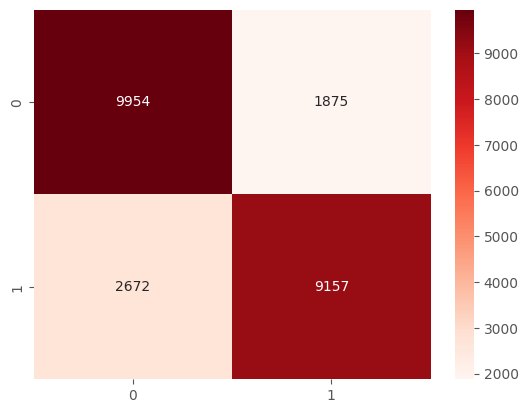

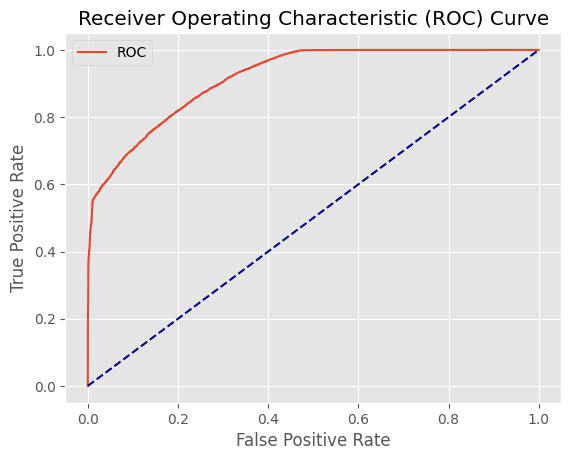

AUC: 0.92


In [223]:
from sklearn.ensemble import RandomForestClassifier

classifier= RandomForestClassifier()

parameters = {'n_estimators' : [19,20,21,22,23],
    'criterion' : ['gini'],
             'max_depth' : [6,7,8,9,10], 
             'min_samples_split' : [2,3,4],
              'min_samples_leaf' : [4,5,6]
             }

matrix_RandFor, auc_RandFor, fpr_RandFor, tpr_RandFor, best_model_RandFor, best_param_RandFor=total(classifier,parameters,X_train,y_train,X_test,y_test)

f1_train: 0.799756 using {'learning_rate': 0.021, 'n_estimators': 2000}
f1         train 0.800   test 0.799
precision  train 0.825   test 0.822
recall  train 0.776   test 0.777

[[9845 1984]
 [2637 9192]]
              precision    recall  f1-score   support

       False       0.79      0.83      0.81     11829
        True       0.82      0.78      0.80     11829

    accuracy                           0.80     23658
   macro avg       0.81      0.80      0.80     23658
weighted avg       0.81      0.80      0.80     23658



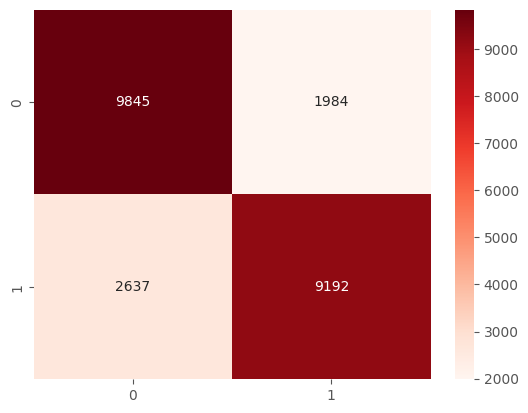

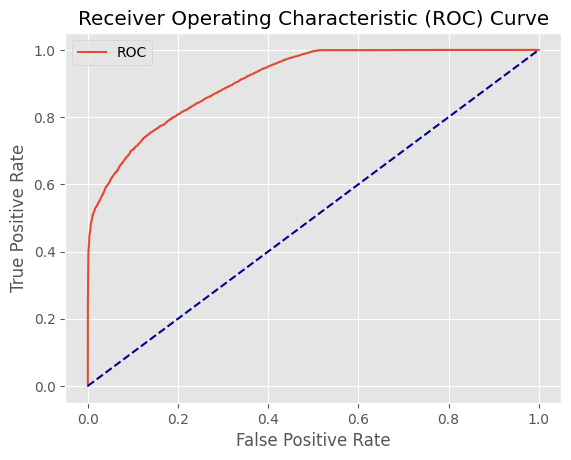

AUC: 0.91


In [224]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

classifier= AdaBoostClassifier()

parameters = {'n_estimators' : [1500,2000,2500],
    'learning_rate' : [ 0.019,0.02 ,0.021,0.025  ]}

matrix_AdaB, auc_AdaB, fpr_AdaB, tpr_AdaB, best_model_AdaB, best_param_AdaB=total(classifier,parameters,X_train,y_train,X_test,y_test)

f1_train: 0.799574 using {}
f1         train 0.800   test 0.799
precision  train 0.826   test 0.823
recall  train 0.775   test 0.776

[[9857 1972]
 [2644 9185]]
              precision    recall  f1-score   support

       False       0.79      0.83      0.81     11829
        True       0.82      0.78      0.80     11829

    accuracy                           0.80     23658
   macro avg       0.81      0.80      0.80     23658
weighted avg       0.81      0.80      0.80     23658



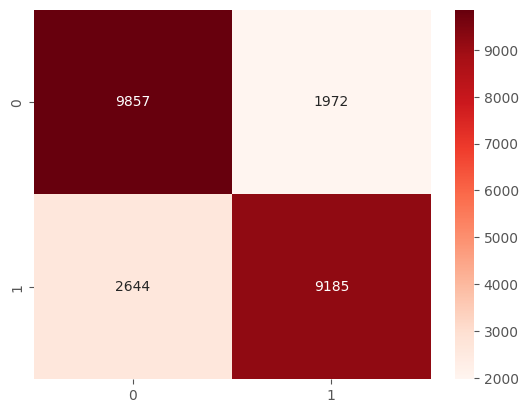

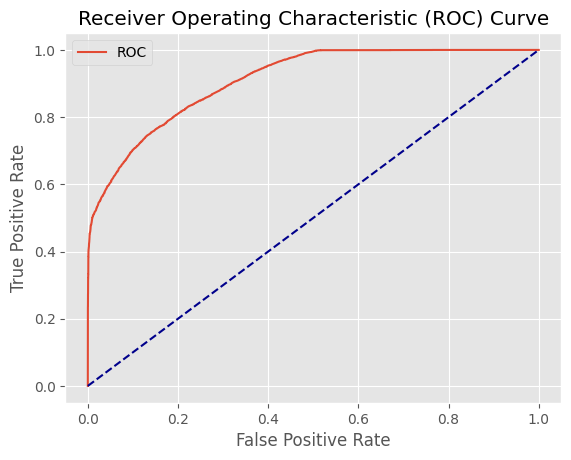

AUC: 0.91


In [225]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model_NB = GaussianNB()

matrix_NB, auc_NB, fpr_NB, tpr_NB, best_model_NB, best_param_NB =total(classifier,{},X_train,y_train,X_test,y_test)

f1_train: 0.791477 using {'C': 10, 'max_iter': 600}
f1         train 0.792   test 0.790
precision  train 0.801   test 0.798
recall  train 0.782   test 0.782

[[9487 2342]
 [2584 9245]]
              precision    recall  f1-score   support

       False       0.79      0.80      0.79     11829
        True       0.80      0.78      0.79     11829

    accuracy                           0.79     23658
   macro avg       0.79      0.79      0.79     23658
weighted avg       0.79      0.79      0.79     23658



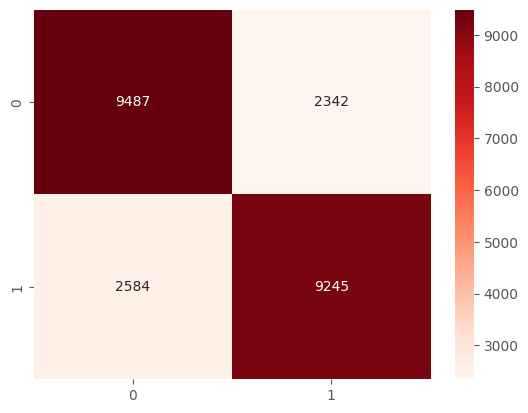

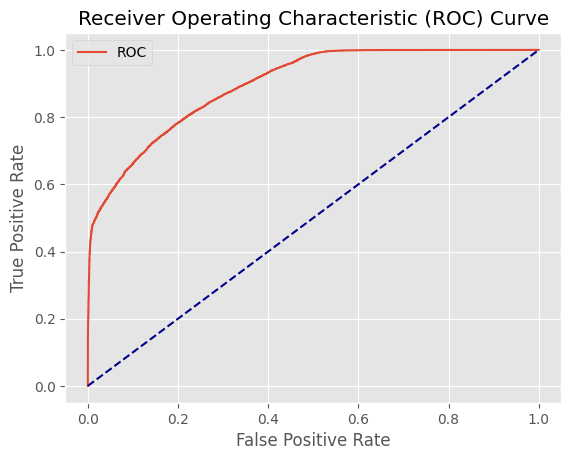

AUC: 0.90


In [226]:
# Logistic

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "max_iter":[600,700,800,900] }


matrix_LR, auc_LR, fpr_LR, tpr_LR, best_model_LR, best_param_LR =total(classifier,parameters,X_train,y_train,X_test,y_test)

f1_train: 0.803772 using {'C': 30, 'kernel': 'rbf', 'probability': True}
f1         train 0.805   test 0.804
precision  train 0.818   test 0.814
recall  train 0.793   test 0.793

[[9682 2147]
 [2443 9386]]
              precision    recall  f1-score   support

       False       0.80      0.82      0.81     11829
        True       0.81      0.79      0.80     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



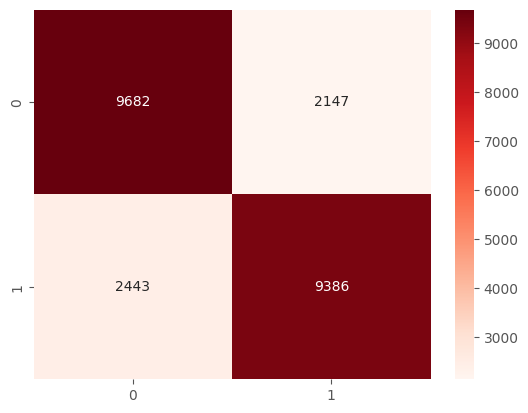

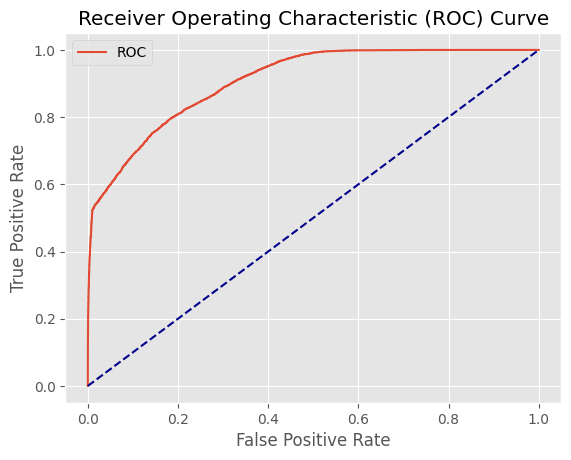

AUC: 0.91


In [227]:
#SVM

from sklearn.svm import SVC

classifier = SVC()

parameters = {"kernel":['rbf'], "C":[0.1,30,40],"probability":[True]}

matrix_SVM, auc_SVM, fpr_SVM, tpr_SVM, best_model_SVM, best_param_SVM=total(classifier,parameters,X_train,y_train,X_test,y_test)

f1_train: 0.813445 using {'alpha': 0.1, 'hidden_layer_sizes': (150, 50, 10), 'learning_rate': 'adaptive', 'max_iter': 1000}
f1         train 0.810   test 0.810
precision  train 0.807   test 0.804
recall  train 0.812   test 0.815

[[9477 2352]
 [2186 9643]]
              precision    recall  f1-score   support

       False       0.81      0.80      0.81     11829
        True       0.80      0.82      0.81     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



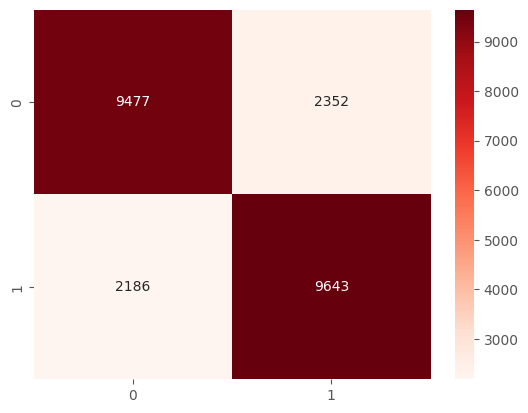

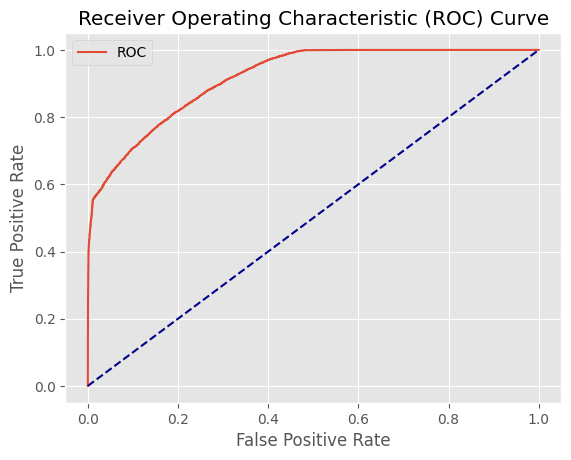

AUC: 0.92


In [229]:
# Multi-layer Perceptron classifier

from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()

parameters = {"hidden_layer_sizes":[(100,20,5),(150,50,10)],  "max_iter": [1000,2000,3000,3500], "alpha": [0.05,0.1,0.2,0.3],"learning_rate":['adaptive']}

matrix_MLP, auc_MLP, fpr_MLP, tpr_MLP, best_model_MLP, best_param_MLP=total(classifier,parameters,X_train,y_train,X_test,y_test)

f1_train: 0.810621 using {'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'log_loss', 'n_estimators': 55}
f1         train 0.815   test 0.811
precision  train 0.820   test 0.814
recall  train 0.810   test 0.808

[[9646 2183]
 [2268 9561]]
              precision    recall  f1-score   support

       False       0.81      0.82      0.81     11829
        True       0.81      0.81      0.81     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



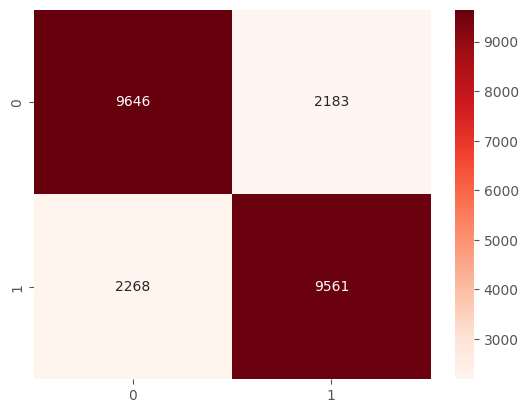

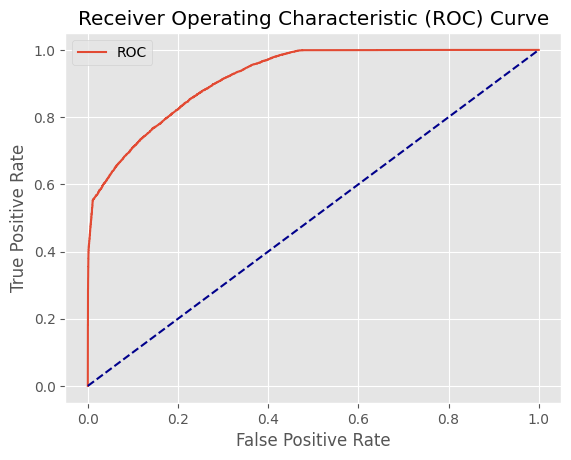

AUC: 0.92


In [230]:
# Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier 

classifier = GradientBoostingClassifier()

parameters = {'loss':['log_loss'],'criterion':['friedman_mse','squared_error'],'learning_rate':[1.1,1,0.9,0.8,1.2,1.3],'n_estimators':[53,54,55,56,70]}

matrix_GB, auc_GB, fpr_GB, tpr_GB, best_model_GB, best_param_GB=total(classifier,parameters,X_train,y_train,X_test,y_test)

f1_train: 0.810642 using {'estimator': GradientBoostingClassifier(learning_rate=1, n_estimators=55), 'n_estimators': 10, 'random_state': 2}
f1         train 0.816   test 0.813
precision  train 0.818   test 0.814
recall  train 0.813   test 0.812

[[9639 2190]
 [2225 9604]]
              precision    recall  f1-score   support

       False       0.81      0.81      0.81     11829
        True       0.81      0.81      0.81     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



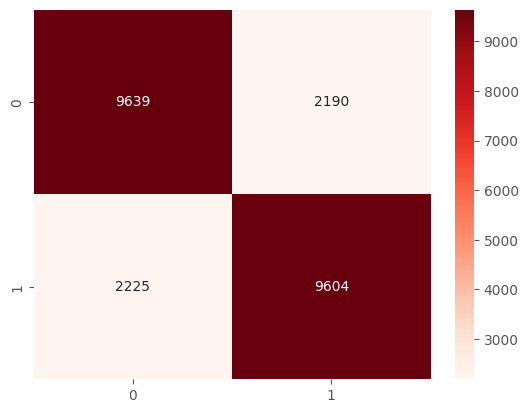

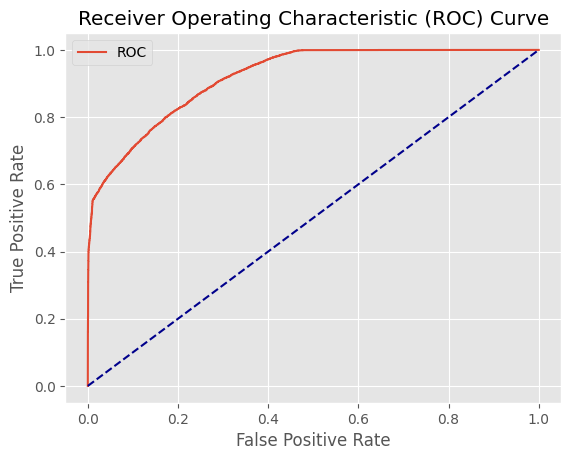

AUC: 0.92


In [231]:
#Bagging with Gradient Boosting
from sklearn.ensemble import BaggingClassifier

classifier = BaggingClassifier()
base = GradientBoostingClassifier(criterion='friedman_mse',learning_rate=1,n_estimators=55,loss='log_loss')

parameters = {'n_estimators':[8,9,10,11,12,13],'estimator':[base],'random_state':[2]}

matrix_BagGB, auc_BagGB, fpr_BagGB, tpr_BagGB, best_model_BagGB, best_param_BaaGB = total(classifier,parameters,X_train,y_train,X_test,y_test)


f1_train: 0.811465 using {'estimator': GradientBoostingClassifier(learning_rate=1, n_estimators=55), 'learning_rate': 0.1, 'n_estimators': 11, 'random_state': 2}
f1         train 0.817   test 0.813
precision  train 0.820   test 0.816
recall  train 0.813   test 0.811

[[9672 2157]
 [2240 9589]]
              precision    recall  f1-score   support

       False       0.81      0.82      0.81     11829
        True       0.82      0.81      0.81     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



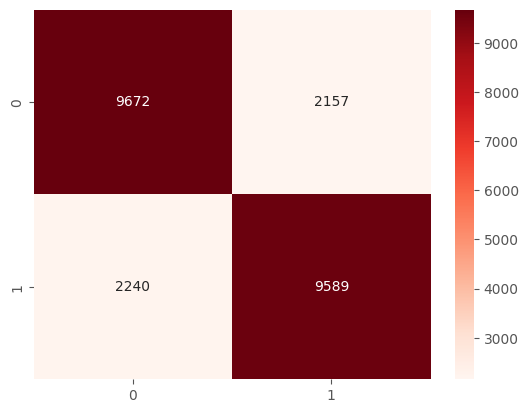

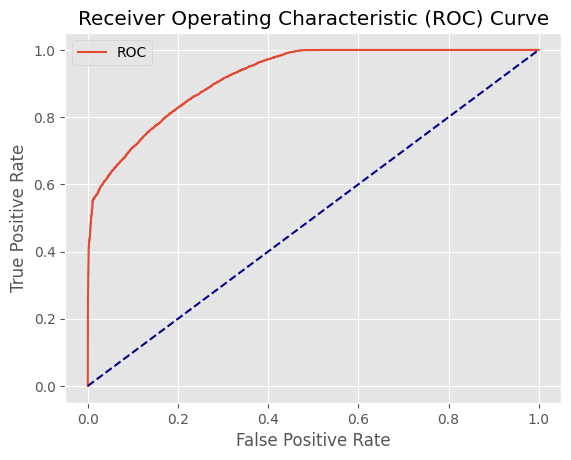

AUC: 0.92


In [232]:
#AdaBoost with Gradient Boosting
classifier = AdaBoostClassifier()
base = GradientBoostingClassifier(criterion='friedman_mse',learning_rate=1,n_estimators=55,loss='log_loss')

parameters = {'n_estimators':[8,9,10,11,12,13],'estimator':[base], 'learning_rate' :[0.05,0.10,0.2],'random_state':[2]}

matrix_AdaGB, auc_AdaGB, fpr_AdaGB, tpr_AdaGB, best_model_AdaGB, best_param_AdaGB = total(classifier,parameters,X_train,y_train,X_test,y_test)


f1_train: 0.804170 using {'estimator': DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=17), 'n_estimators': 8, 'random_state': 2}
f1         train 0.805   test 0.802
precision  train 0.829   test 0.824
recall  train 0.782   test 0.781

[[9854 1975]
 [2586 9243]]
              precision    recall  f1-score   support

       False       0.79      0.83      0.81     11829
        True       0.82      0.78      0.80     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



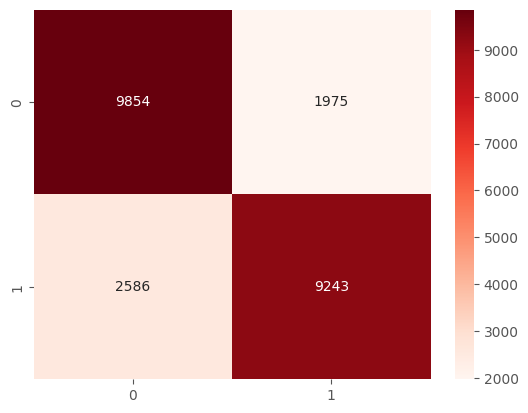

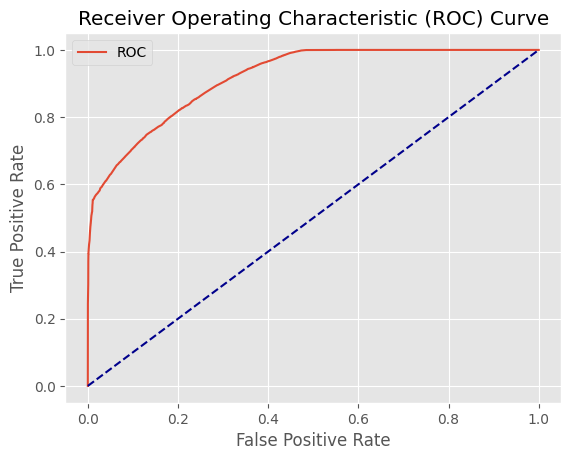

AUC: 0.92


In [233]:
#Bagging with tree
classifier = BaggingClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17)

parameters = {'n_estimators':[4,5,6,7,8,9],'estimator':[base],'random_state':[2]}

matrix_Bagtree, auc_Bagtree, fpr_Bagtree, tpr_Bagtree, best_model_Bagtree, best_param_Bagtree = total(classifier,parameters,X_train,y_train,X_test,y_test)


f1_train: 0.809262 using {'estimator': DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=17), 'learning_rate': 0.6, 'n_estimators': 8, 'random_state': 2}
f1         train 0.817   test 0.813
precision  train 0.817   test 0.811
recall  train 0.818   test 0.815

[[9578 2251]
 [2185 9644]]
              precision    recall  f1-score   support

       False       0.81      0.81      0.81     11829
        True       0.81      0.82      0.81     11829

    accuracy                           0.81     23658
   macro avg       0.81      0.81      0.81     23658
weighted avg       0.81      0.81      0.81     23658



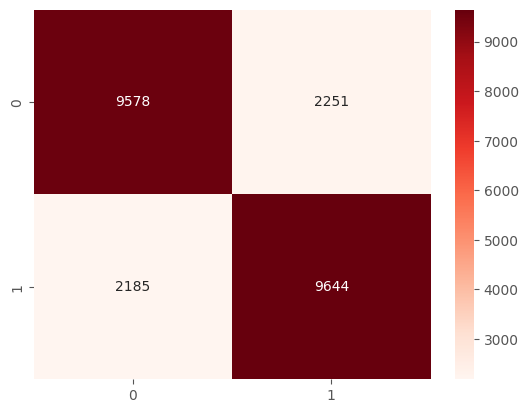

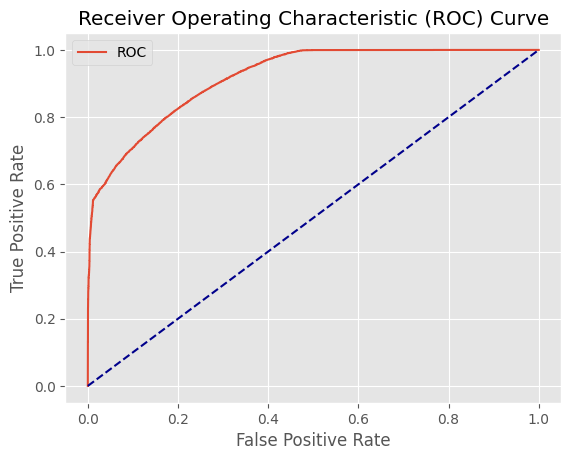

AUC: 0.92


In [234]:
#AdaBoost with tree
classifier = AdaBoostClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17)

parameters = {'n_estimators':[4,6,7,8,9,10,11],'estimator':[base], 'learning_rate' :[0.5,0.6,0.7,0.8,0.9,1],'random_state':[2]}

matrix_Adatree, auc_Adatree, fpr_Adatree, tpr_Adatree, best_model_Adatree, best_param_Adatree = total(classifier,parameters,X_train,y_train,X_test,y_test)

In [235]:
# Create a dataframe with the results of the hyperparameter tuning
f1_train_values = [matrix_KNN[0][0], matrix_tree[0][0], matrix_RandFor[0][0], matrix_AdaB[0][0], matrix_NB[0][0], matrix_LR[0][0], matrix_SVM[0][0], matrix_MLP[0][0], matrix_GB[0][0], matrix_BagGB[0][0], matrix_AdaGB[0][0], matrix_Bagtree[0][0], matrix_Adatree[0][0]]
f1_test_values = [matrix_KNN[0][1], matrix_tree[0][1], matrix_RandFor[0][1], matrix_AdaB[0][1], matrix_NB[0][1], matrix_LR[0][1], matrix_SVM[0][1], matrix_MLP[0][1], matrix_GB[0][1], matrix_BagGB[0][1], matrix_AdaGB[0][1], matrix_Bagtree[0][1], matrix_Adatree[0][1]]

df_results = pd.DataFrame({'f1_train': f1_train_values, 'f1_test': f1_test_values}, index=['KNN', 'Tree', 'RandForest', 'AdaBoost', 'Naive Bayes', 'Logistic Regression', 'SVM', 'MultiLayerPerceptron', 'Gradient Boosting', 'Bagging Gradient Boosting', 'Adaboost Gradient Boosting', 'Bagging tree', 'Adaboost tree'])

df_results

,f1_train,f1_test
KNN,0.820594,0.807140
Tree,0.812644,0.810981
RandForest,0.807431,0.801102
AdaBoost,0.799892,0.799131
Naive Bayes,0.799640,0.799182
Logistic Regression,0.791503,0.789631
SVM,0.804867,0.803527
MultiLayerPerceptron,0.809734,0.809520
Gradient Boosting,0.814918,0.811182
Bagging Gradient Boosting,0.815724,0.813106


No overfitting (low difference between the results on train and test)

## BEST MODEL
Adaboost classifier with hyperparameters:
- 'learning_rate' = 0.1
- 'n_estimators' = 11
-  'estimator'= GradientBoosting:
    - 'learning_rate' = 1
    - 'n_estimators' = 55
    - 'loss' = 'log_loss'
    - 'criterion' = 'friedman_mse'   
    
       
Let's make a deeper analysis on the chosen model and then fit it on the whole training set (no more split).


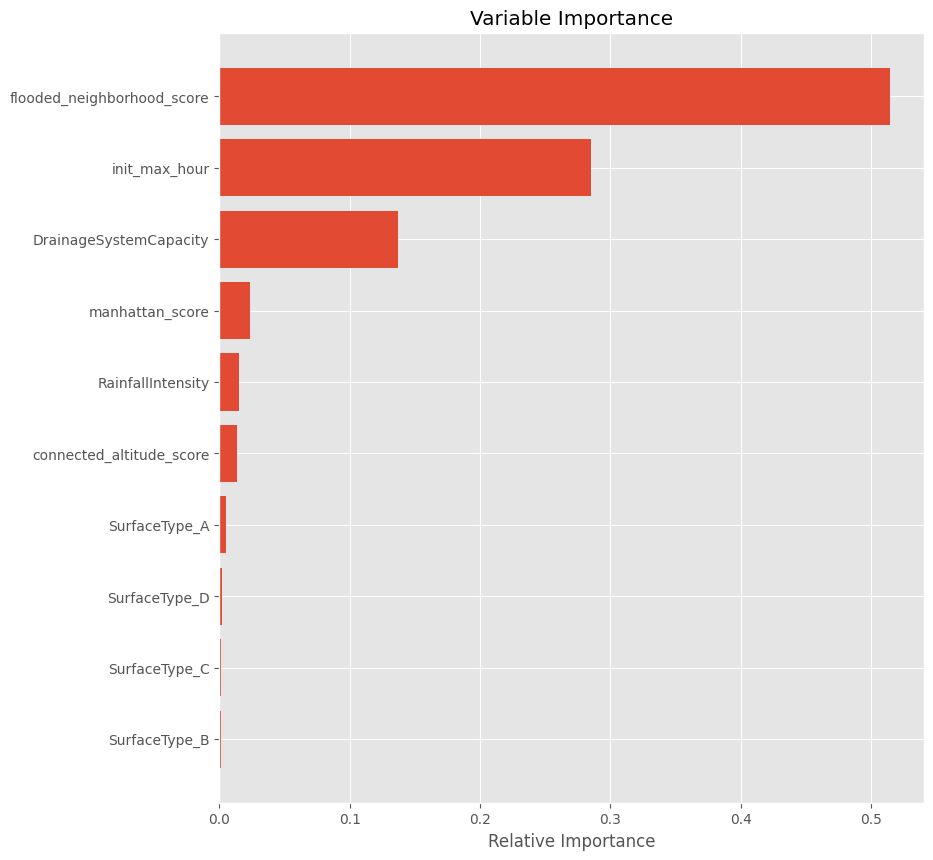

In [236]:
#Plot the feature importance of the best model
feature_importance = best_model_AdaGB.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [237]:
# Fitting the best model on the whole training set
best_model = AdaBoostClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse',learning_rate=1,n_estimators=55,loss='log_loss'),
                                learning_rate=0.1,
                                n_estimators=11,
                                random_state=2)
best_model.fit(X, y)


AdaBoostClassifier(estimator=GradientBoostingClassifier(learning_rate=1,
                                                        n_estimators=55),
                   learning_rate=0.1, n_estimators=11, random_state=2)

In [238]:
#Let's save the model for future implementation
import pickle

with open('/Users/francesco/Desktop/new_csv_normale+init/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [239]:
#Let's save the scaler for future implementation  
with open('/Users/francesco/Desktop/new_csv_normale+init/scaler.pkl', 'wb') as file:
    pickle.dump(minmax_scaler, file)

## PREDICTIONS
Predict the target variable for the test set called df_test.

Being a unique dataframe and not divided in 200 csv, I will sort it by Observation Index, head_id and tail_id, and make a copy that will be used for the submission (200 csv, one for each simulation).

After the copy, I will mantain only the columns useed during training in order to predict the target variable and so i will drop head_id, tail_id and ObservationIndex.

As I have the predictions, in the dataframe copy (that has head_id, tail_id and ObservationIndex essentials for the submission) i can create the column flooded_final (target variable) fed with the predictions, being sure that the prediction are alligned with the right road and ObesrvationIndex (because they were sorted at the same way in the beginning).

In [240]:
df_test=df_test.sort_values(by=['ObservationIndex','head_id','tail_id']) #sort the test dataframe by ObservationIndex, head_id and tail_id
df_test.reset_index(drop=True, inplace=True) #reset the index
df_test

,head_id,tail_id,flooded_init,ObservationIndex,connected_altitude_score,manhattan_score,flooded_neighborhood_score,RainfallIntensity,init_max_hour,DrainageSystemCapacity,SurfaceType_A,SurfaceType_B,SurfaceType_C,SurfaceType_D
0,151779659,152136099,False,0,0.203673,0.678052,0.12,0.666667,0.5,0.60,False,False,False,True
1,151779659,152426116,False,0,0.417998,0.609135,0.12,0.666667,0.5,0.60,False,False,False,True
2,151779659,153066427,True,0,0.200869,0.743045,0.60,0.666667,0.5,0.60,False,False,False,True
3,151779763,152437059,False,0,0.174516,0.733440,0.00,0.666667,0.5,0.60,False,False,False,True
4,151779763,152541738,False,0,0.276983,0.726169,0.00,0.666667,0.5,0.60,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38195,153295319,153341528,False,199,0.502944,0.753141,0.00,0.000000,0.5,0.05,False,False,True,False
38196,153444946,153444951,False,199,0.199047,0.765524,0.00,0.000000,0.5,0.05,False,False,True,False
38197,153456725,153456737,False,199,0.337819,0.785495,0.00,0.000000,0.5,0.05,False,False,True,False
38198,1191806314,1191806355,False,199,0.395430,0.829266,0.00,0.000000,0.5,0.05,False,False,True,False


In [241]:
df_test_copy=df_test.copy() #create a copy of the test dataframe to use it for the submission

df_test.drop(['ObservationIndex','head_id','tail_id',
              'flooded_init'], axis=1, inplace=True) #drop the ObservationIndex column for the test dataframe that were not present during fitting

df_test

,connected_altitude_score,manhattan_score,flooded_neighborhood_score,RainfallIntensity,init_max_hour,DrainageSystemCapacity,SurfaceType_A,SurfaceType_B,SurfaceType_C,SurfaceType_D
0,0.203673,0.678052,0.12,0.666667,0.5,0.60,False,False,False,True
1,0.417998,0.609135,0.12,0.666667,0.5,0.60,False,False,False,True
2,0.200869,0.743045,0.60,0.666667,0.5,0.60,False,False,False,True
3,0.174516,0.733440,0.00,0.666667,0.5,0.60,False,False,False,True
4,0.276983,0.726169,0.00,0.666667,0.5,0.60,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
38195,0.502944,0.753141,0.00,0.000000,0.5,0.05,False,False,True,False
38196,0.199047,0.765524,0.00,0.000000,0.5,0.05,False,False,True,False
38197,0.337819,0.785495,0.00,0.000000,0.5,0.05,False,False,True,False
38198,0.395430,0.829266,0.00,0.000000,0.5,0.05,False,False,True,False


In [242]:
# Predictions on the test set
y_pred = best_model.predict(df_test)
    
df_test_copy['flooded_final'] = y_pred #add the column with the predictions to the test dataframe copy

df_test_copy

,head_id,tail_id,flooded_init,ObservationIndex,connected_altitude_score,manhattan_score,flooded_neighborhood_score,RainfallIntensity,init_max_hour,DrainageSystemCapacity,SurfaceType_A,SurfaceType_B,SurfaceType_C,SurfaceType_D,flooded_final
0,151779659,152136099,False,0,0.203673,0.678052,0.12,0.666667,0.5,0.60,False,False,False,True,True
1,151779659,152426116,False,0,0.417998,0.609135,0.12,0.666667,0.5,0.60,False,False,False,True,True
2,151779659,153066427,True,0,0.200869,0.743045,0.60,0.666667,0.5,0.60,False,False,False,True,True
3,151779763,152437059,False,0,0.174516,0.733440,0.00,0.666667,0.5,0.60,False,False,False,True,False
4,151779763,152541738,False,0,0.276983,0.726169,0.00,0.666667,0.5,0.60,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38195,153295319,153341528,False,199,0.502944,0.753141,0.00,0.000000,0.5,0.05,False,False,True,False,False
38196,153444946,153444951,False,199,0.199047,0.765524,0.00,0.000000,0.5,0.05,False,False,True,False,False
38197,153456725,153456737,False,199,0.337819,0.785495,0.00,0.000000,0.5,0.05,False,False,True,False,False
38198,1191806314,1191806355,False,199,0.395430,0.829266,0.00,0.000000,0.5,0.05,False,False,True,False,False


In [243]:
#drop the columns that are not needed for the submission
df_test_predicted = df_test_copy.drop(["connected_altitude_score","manhattan_score","flooded_neighborhood_score",
                                       "RainfallIntensity","init_max_hour","DrainageSystemCapacity",
                                       "SurfaceType_A","SurfaceType_B","SurfaceType_C","SurfaceType_D"], axis=1) 

df_test_predicted

,head_id,tail_id,flooded_init,ObservationIndex,flooded_final
0,151779659,152136099,False,0,True
1,151779659,152426116,False,0,True
2,151779659,153066427,True,0,True
3,151779763,152437059,False,0,False
4,151779763,152541738,False,0,False
...,...,...,...,...,...
38195,153295319,153341528,False,199,False
38196,153444946,153444951,False,199,False
38197,153456725,153456737,False,199,False
38198,1191806314,1191806355,False,199,False


In [251]:
#Divide df_test_predicted in a dataframe for each simulation
df_test_predicted_list = [x for _, x in df_test_predicted.groupby('ObservationIndex')] #list of dataframes divided by simulation

# Create a csv file for each simulation named with the ObservationIndex and drop the ObservationIndex column
for df in df_test_predicted_list:
    observation_index = df['ObservationIndex'].iloc[0]  # save the ObservationIndex of the current simulation before dropping the column
    df.drop(['ObservationIndex'], axis=1, inplace=True) #drop the ObservationIndex column
    df.to_csv('/Users/francesco/Desktop/df_test_predictions/' + str(observation_index) + '.csv', index=False) #create a csv file for each simulation named with the ObservationIndex
    
